# Conversation Emotion Classifier using Deep Learning Methods and Parallel Computing with PyTorch

# **Contents**

# 1. Problem Statement

# 2. Define the Environment
## 2.1 All Imports

# 3. Exploratory Data Analysis
## 3.1 About the Dataset
## 3.2 Size of the Dataset
## 3.3 Distribution of Emotions
## 3.4 Distribution of Each Type of Audio File
## 3.5 Average Duration of the Audio Files Utilizing **Parallelization**
## 3.6 Pitch Analysis on Few of the Emotions
## 3.7 Waveform Visualizations for Few of the Emotions
## 3.8 Power Spectrums Visualizations by Performing Fourier Transformations
## 3.9 Spectrogram Visualizations
## 3.10 MFCC Visualizations

# 4. Data Preprocessing
## 4.1 Check and Remove Bias Utilizing **Parallelization**
## 4.2 Load the Emotions
## 4.3 Calculate Mel Spectrogram Utilizing **Parallelization**

# 5. Model Development
## 5.1 Model Introduction
## 5.2 CNN Model Using Pytorch Without **Parallelism**
## 5.3 Resnet50 Model Using Pytorch Without **Parallelism**
## 5.4 Resnet50 Model with **Parallelism (data parallel)**

# 6. Model Evaluation

# 7. Parallel Techniques for Selected Model Training - Ideal number of CPUs
## 7.1 CNN Model Using Pytorch With **Data Parallel** Method Having 1 GPU
## 7.2 CNN Model Using Pytorch With **Data Parallel** Method Having 2 GPU
## 7.3 CNN Model Using Pytorch With **Data Parallel** Method Having 4 GPU
## 7.4 CNN Model Using Pytorch With **Distributed Data Parallel** Method Having 1 GPU
## 7.5 CNN Model Using Pytorch With **Distributed Data Parallel** Method Having 2 GPU
## 7.6 CNN Model Using Pytorch With **Distributed Data Parallel** Method Having 4 GPU

# 8. Comparing the Execution Time, Speedup, and Execution Time for each number of GPUs
## 8.1 Compare for Data Parallel Method
## 8.2 Compare for Distributed Data Parallel Method

# 9. Conclusion for Ideal Parallel Method and Number of GPUs

# 10. References


# 1. **Problem Statement**

Emotion recognition from audio data is a challenging yet crucial task with applications spanning various fields such as human-computer interaction, music information retrieval, and mental health care. The inherent complexity and variability of human emotions add layers of difficulty to this task.

The process involves analyzing vast amounts of complex and high-dimensional audio data. Traditional sequential computing methods can be time-consuming and computationally expensive, making real-time or large-scale emotion recognition from audio data impractical.

This is where parallel computing comes into play. By dividing the computational workload across multiple processing units, parallel computing allows for the simultaneous analysis of different portions of the audio data. This not only accelerates the processing time but also enhances the efficiency of the emotion recognition task.

However, implementing parallel computing is not straightforward. It requires careful consideration of data partitioning, task allocation, and synchronization to ensure accurate and efficient computation. Furthermore, the choice of parallel computing method (such as Data Parallel or Distributed Data Parallel) and the number of processing units (CPUs or GPUs) can significantly impact the performance and speedup of the emotion recognition task.

Therefore, the problem at hand is not just about classifying emotions from audio data, but also about how to effectively leverage parallel computing to overcome the computational challenges associated with this task.


# 2. **Define the environment**

- os: This module provides a way of using operating system dependent functionality like reading or writing to the environment, manipulating paths, etc.

- time: This module is used for time-related tasks.

- warnings: This module is used to warn the user of some condition in the program, where that condition (normally) doesn’t warrant raising an exception and terminating the program. Here, it’s used to ignore warnings.

- numpy: This package is used for numerical computations.

- matplotlib.pyplot: This is a plotting library used for creating static, animated, and interactive visualizations in Python.

- librosa and librosa.display: These are used for music and audio analysis.

- soundfile: This is used to read and write sound files in various formats.

- multiprocessing.Pool: This is used for creating a pool of worker processes. It’s part of the parallel computing implementation.

- glob: This module is used to retrieve files/pathnames matching a specified pattern.

- skimage.transform.resize: This is used to resize images.

- tqdm: This is used to show progress bars.

- torch, torch.nn, torch.optim, torch.multiprocessing, torch.distributed, and torch.nn.parallel.DistributedDataParallel: These are PyTorch modules used for building and training neural networks, and for parallel and distributed computing.

- torch.utils.data.DataLoader and torch.utils.data.TensorDataset: These are used for loading the dataset in parallel using multiprocessing workers.

- sklearn.model_selection.train_test_split: This is used to split the data into training and testing sets.

- torchaudio: This is used to load audio data into PyTorch.

- train_script.train, train_script.Net: These are custom modules for training the model and defining the network architecture.

## 2.1 **All imports**

In [1]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from multiprocessing import Pool, cpu_count
from glob import glob
from skimage.transform import resize
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torchaudio
import torch.nn.functional as F
import gc
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from ddp import train, Net
from concurrent.futures import ThreadPoolExecutor


warnings.filterwarnings("ignore")

/home/mothakapally.s/.conda/envs/newenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. **Exploratory Data Analysis**

- Exploratory Data Analysis (EDA) is a crucial step in any data-driven project, including ours. It involves understanding and summarizing the main characteristics of a dataset, often through visual methods. Here's why EDA is essential for our project.

- Before we can build models to recognize emotions from audio data, we need to understand the nature of the data we're dealing with. EDA helps us gain insights into the dataset's structure, variables, and relationships. This understanding guides us in deciding how to preprocess the data and select appropriate modeling techniques.

- EDA is also useful for spotting anomalies and outliers in the data. Anomalies could be errors that need to be corrected, or they might be interesting events that we want to understand better. Either way, identifying these early on helps improve the quality of our data and the accuracy of our model.

- Finally, EDA allows us to test some of the assumptions we might have about the data. Validating these assumptions can help prevent costly mistakes down the line.

In our project, EDA will involve tasks such as understanding the distribution of emotions, analyzing the types and duration of audio files, and visualizing waveforms, power spectrums, spectrograms, and Mel Frequency Cepstral Coefficients (MFCCs). This analysis will provide a solid foundation for the subsequent data preprocessing and model development stages.

## 3.1 **About the dataset**

- This dataset is a comprehensive collection of audio files from four different sources: RAVDESS, CREMA-D, SAVEE, and TESS. The recordings are sorted into seven categories based on the emotion expressed: Angry, Happy, Sad, Neutral, Fearful, Disgusted, and Surprised.

- Here’s a brief breakdown:

1. Angry: Contains 2167 records, making up 16.7% of the dataset.
2. Happy: Contains 2167 records, making up 16.46% of the dataset.
3. Sad: Contains 2167 records, making up 16.35% of the dataset.
4. Neutral: Contains 1795 records, making up 14.26% of the dataset.
5. Fearful: Contains 2047 records, making up 16.46% of the dataset.
6. Disgusted: Contains 1863 records, making up 15.03% of the dataset.
7. Surprised: Contains 592 records, making up 4.74% of the dataset.

- In terms of the source of these files:

1. CREMA-D (Crowd-sourced Emotional Multimodal Actors Dataset) contributes the most with 7442 files, which is about 58.15% of the total data.
2. TESS (Transiting Exoplanet Survey Satellite) provides 2800 files, approximately 21.88% of the total data.
3. RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) adds another 2076 files, around 16.22% of the total data.
4. SAVEE (Surrey Audio-Visual Expressed Emotion) contributes the least with 480 files, making up about 3.75% of the total data.


In [2]:
# Define the directory where the data is stored
directory = '/home/mothakapally.s/Project/data/Emotions'

# Define the emotions
emotions = ['Angry', 'Happy', 'Sad', 'Neutral', 'Fearful', 'Disgusted', 'Surprised']

## 3.2 **Size of the Dataset**

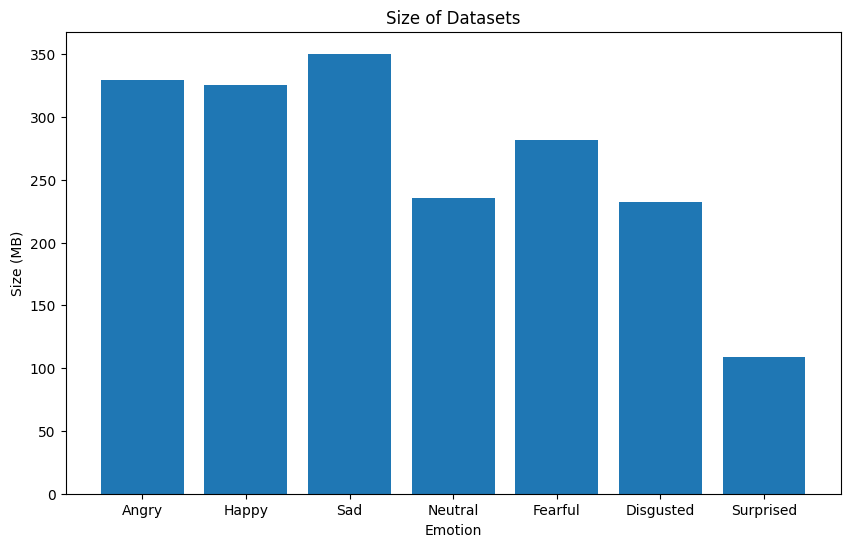

The total size of all datasets is 1864.2015266418457 MB.


In [3]:
def get_dir_size(directory):
    total = 0
    with os.scandir(directory) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

# Calculate the size of each subfolder
sizes = []
total_size = 0
for emotion in emotions:
    size = get_dir_size(os.path.join(directory, emotion))
    sizes.append(size)
    total_size += size

# Convert sizes to MB
sizes_MB = [size / (1024 * 1024) for size in sizes]
total_size_MB = total_size / (1024 * 1024)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, sizes_MB)
plt.title('Size of Datasets')
plt.xlabel('Emotion')
plt.ylabel('Size (MB)')
plt.show()

# Print the total size of all datasets
print(f"The total size of all datasets is {total_size_MB} MB.")

**Observation**
- The total size of the audio data is almost 2 GB


## 3.3 **distribution of Emotions**

- Understanding the distribution of emotions in the audio data can help us identify if there's a class imbalance problem. Class imbalance could lead to a biased model that is more likely to predict the majority class. 

- Furthermore, understanding the distribution of each type of audio file can help us identify patterns or trends specific to each emotion. This could be useful in feature engineering and model selection.

- Therefore, a thorough analysis of the distribution of the dataset is essential for building an effective and unbiased emotion recognition model.

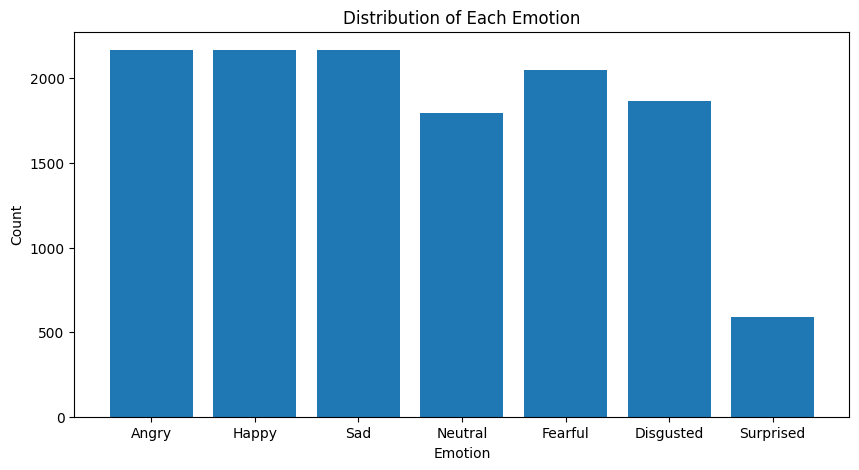

In [4]:
# Initialize a dictionary to hold the count of files for each emotion
emotion_counts = {emotion: 0 for emotion in emotions}

# Loop over the emotions
for emotion in emotions:
    # Get the list of files for this emotion
    files = os.listdir(os.path.join(directory, emotion))
    # Update the counts
    emotion_counts[emotion] += len(files)

# Plot the distribution of each emotion
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Distribution of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

**Observation**

- From the graph, we can observe that the emotions of Angry, Happy, and Sad have very similar counts, each just above 2000 occurrences. The count for Neutral is somewhat lower. Fearful and Disgusted have approximately similar counts that are less than Neutral but still significant. However, the count for Surprised is notably lower, with only around 500 occurrences.

- This distribution suggests a potential **class imbalance** in our dataset. While Angry, Happy, and Sad are well-represented, the Surprised class is underrepresented. This imbalance could lead to a model that is less accurate in recognizing the **Surprised emotion** compared to the others. Therefore, addressing this class imbalance should be a consideration in our data preprocessing stage.

## 3.4 **Distribution of each type of audio file**

- Analyzing the distribution of each type of audio file is an essential part of the exploratory data analysis. This analysis provides insights into the variety and balance of the audio data we have for each emotion.

- In the context of emotion recognition, each type of audio file corresponds to a different emotion. Therefore, understanding the distribution of these audio files can help us identify potential biases in our dataset. For instance, if certain emotions are overrepresented in the audio files, our model might become biased towards these emotions. On the other hand, underrepresented emotions might not be recognized as accurately.

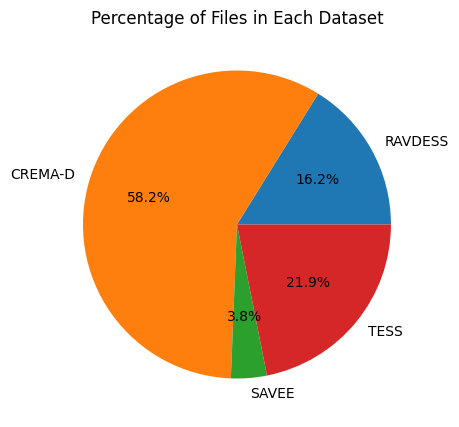

In [5]:
# Initialize a dictionary to hold the count of files for each dataset
dataset_counts = {'RAVDESS': 0, 'CREMA-D': 0, 'SAVEE': 0, 'TESS': 0}

# Loop over the emotions
for emotion in emotions:
    # Get the list of files for this emotion
    files = os.listdir(os.path.join(directory, emotion))
    # Loop over the files
    for file in files:
        # Update the dataset counts based on the filename prefix
        if file.startswith('03'):
            dataset_counts['RAVDESS'] += 1
        elif file.startswith('10'):
            dataset_counts['CREMA-D'] += 1
        elif file.startswith('OAF') or file.startswith('YAF'):
            dataset_counts['TESS'] += 1
        else:
            dataset_counts['SAVEE'] += 1

# Plot the pie chart
plt.figure(figsize=(10, 5))
plt.pie(dataset_counts.values(), labels=dataset_counts.keys(), autopct='%1.1f%%')
plt.title('Percentage of Files in Each Dataset')
plt.show()


**Observation**

CREMA-D constitutes the majority of the files, with more than half of the pie, at 51.1%.

TESS represents 27.4% of the files, making it the second-largest portion of the dataset.

RAVDESS makes up 18.1% of the files, which is a significant portion but less than both CREMA-D and TESS.

SAVEE has the smallest share, with only 3.3% of the files.

Overall, the chart indicates that CREMA-D is the most dominant dataset in this collection, whereas SAVEE is the least represented.

## 3.5 **Average duration of the audio files**

- The average duration of the audio files is a crucial characteristic to understand in our dataset. It can provide insights into the length of the audio samples we're dealing with, which can impact the design of our model. For instance, shorter audio clips might require different handling compared to longer ones. 

In [6]:
# Function to process each file
def process_file(directory, emotion, file):
    duration = librosa.get_duration(filename=os.path.join(directory, emotion, file))
    return emotion, duration

# Initialize empty dictionary to hold durations
durations = {emotion: [] for emotion in emotions}

# Start the timer
start_time = time.time()

# Calculate duration for each file
for emotion in emotions:
    files = [f for f in os.listdir(os.path.join(directory, emotion)) if f.endswith('.wav')]
    for file in files:
        emotion, duration = process_file(directory, emotion, file)
        durations[emotion].append(duration)

# Stop the timer
end_time = time.time()

# Calculate average durations
average_durations = {emotion: sum(durations[emotion])/len(durations[emotion]) for emotion in durations.keys()}

#store the execution_time
execution_time = end_time - start_time
# Print the execution time
print(f"Execution time: {execution_time} seconds")

Execution time: 216.4444296360016 seconds


**Observation**

- It took a lot of time to perform this task and hence we should look for a way to lower the execution time

## Let's introduce parallelism here

- Calculating the duration of each audio file can be a time-consuming process, especially when dealing with a large dataset. This is where parallel computing comes in handy. By using the `multiprocessing.Pool` method, we can distribute the task of calculating durations across multiple CPUs. This approach, known as parallelization, can significantly speed up the computation.

## **Pool.map**

- In Python, the `Pool.map` function is a built-in method that applies a function to every item of an iterable, such as a list or array. When used in conjunction with `multiprocessing.Pool`, it allows us to perform these operations in parallel, utilizing multiple CPUs to process the data concurrently. This can lead to a substantial reduction in the overall computation time, making our exploratory data analysis more efficient.

In [7]:
# Function to process each file
def process_file(args):
    directory, emotion, file = args
    duration = librosa.get_duration(filename=os.path.join(directory, emotion, file))
    return emotion, duration

# Initialize empty dictionary to hold durations
durations = {emotion: [] for emotion in emotions}

# Start the timer
start_time = time.time()

# Create a pool of worker processes
with Pool(os.cpu_count()) as p:
    # Calculate duration for each file
    for emotion in emotions:
        files = [f for f in os.listdir(os.path.join(directory, emotion)) if f.endswith('.wav')]
        args = [(directory, emotion, file) for file in files]
        results = p.map(process_file, args)
        for emotion, duration in results:
            durations[emotion].append(duration)

# Stop the timer
end_time = time.time()

# Calculate average durations
average_durations = {emotion: sum(durations[emotion])/len(durations[emotion]) for emotion in durations.keys()}

#store the execution_time
execution_time_map = end_time - start_time

# Print the execution time
print(f"Execution time: {execution_time_map} seconds")

Execution time: 34.52932333946228 seconds


**Observation**

- Pool.map parallel method significantly reduced the execution time

## Lets try another Pool method - **Pool.starmap**

- In Python, the Pool.starmap function is a built-in method that applies a function to every item of an iterable, similar to Pool.map. However, unlike Pool.map, Pool.starmap is designed to handle functions that take multiple arguments. It unpacks each item in the iterable as arguments to the function.

- When used in conjunction with multiprocessing.Pool, Pool.starmap allows us to perform these operations in parallel, utilizing multiple CPUs to process the data concurrently. This can lead to a substantial reduction in the overall computation time, making our exploratory data analysis more efficient.

In [8]:
# Function to process each file
def process_file(directory, emotion, file):
    duration = librosa.get_duration(filename=os.path.join(directory, emotion, file))
    return emotion, duration

# Initialize empty dictionary to hold durations
durations = {emotion: [] for emotion in emotions}

# Start the timer
start_time = time.time()

# Create a pool of worker processes
with Pool(os.cpu_count()) as p:
    # Calculate duration for each file
    for emotion in emotions:
        files = [f for f in os.listdir(os.path.join(directory, emotion)) if f.endswith('.wav')]
        args = [(directory, emotion, file) for file in files]
        results = p.starmap(process_file, args)
        for emotion, duration in results:
            durations[emotion].append(duration)

# Stop the timer
end_time = time.time()

# Calculate average durations
average_durations = {emotion: sum(durations[emotion])/len(durations[emotion]) for emotion in durations.keys()}

# Store the execution time
execution_time_starmap = end_time - start_time

# Print the execution time
print(f"Execution time: {execution_time_starmap} seconds")

Execution time: 34.01381731033325 seconds


**Observation**

- Pool.starmap performed almost similar to pool.map
- However pool.map gave better execution time

## Lets also try **Pool.apply** for comparision

- In Python, the Pool.apply function is a built-in method that applies a function to arguments. Unlike Pool.map and Pool.starmap, Pool.apply does not divide the iterable into chunks for parallel processing. Instead, it blocks until the result is ready. This means that Pool.apply runs a single function call in a separate process, waiting for the result before moving on to the next. This can be useful when the function calls are dependent on the results of previous calls.

In [9]:
# # Function to process each file
# def process_file(directory, emotion, file):
#     duration = librosa.get_duration(filename=os.path.join(directory, emotion, file))
#     return emotion, duration

# # Initialize empty dictionary to hold durations
# durations = {emotion: [] for emotion in emotions}

# # Start the timer
# start_time = time.time()

# # Create a pool of worker processes
# with Pool(os.cpu_count()) as p:
#     # Calculate duration for each file
#     for emotion in emotions:
#         files = [f for f in os.listdir(os.path.join(directory, emotion)) if f.endswith('.wav')]
#         for file in files:
#             emotion, duration = p.apply(process_file, (directory, emotion, file))
#             durations[emotion].append(duration)

# # Stop the timer
# end_time = time.time()

# # Calculate average durations
# average_durations = {emotion: sum(durations[emotion])/len(durations[emotion]) for emotion in durations.keys()}

# # Store the execution time
# execution_time_apply = end_time - start_time

# # Print the execution time
# print(f"Execution time: {execution_time_apply} seconds")

**Observation**

- We had to stop executing this cell as it took more time to compare than non parallel method and hence it was a waste of time to even consider pool.apply method

## **Comparing Execution Times, Speedup, and Efficiency**

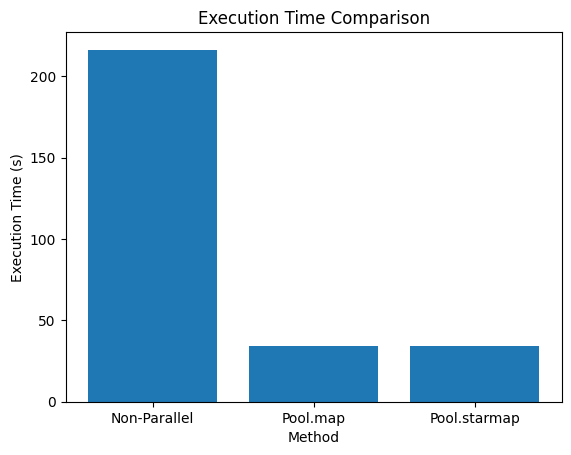

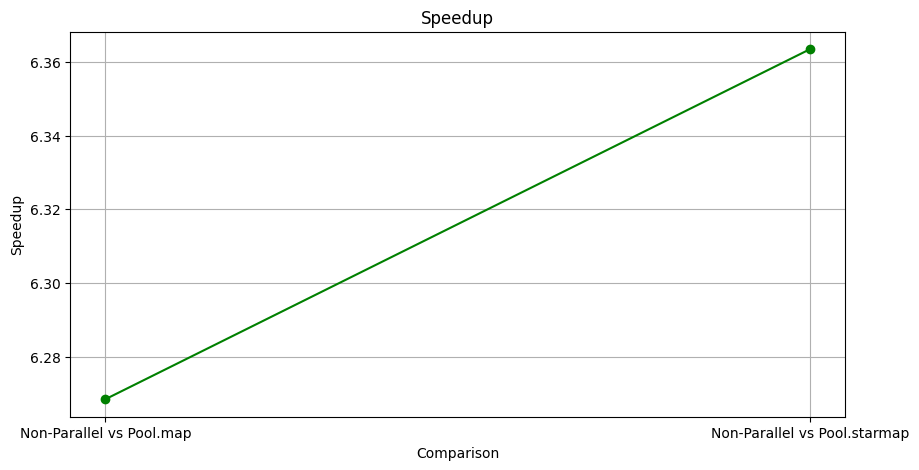

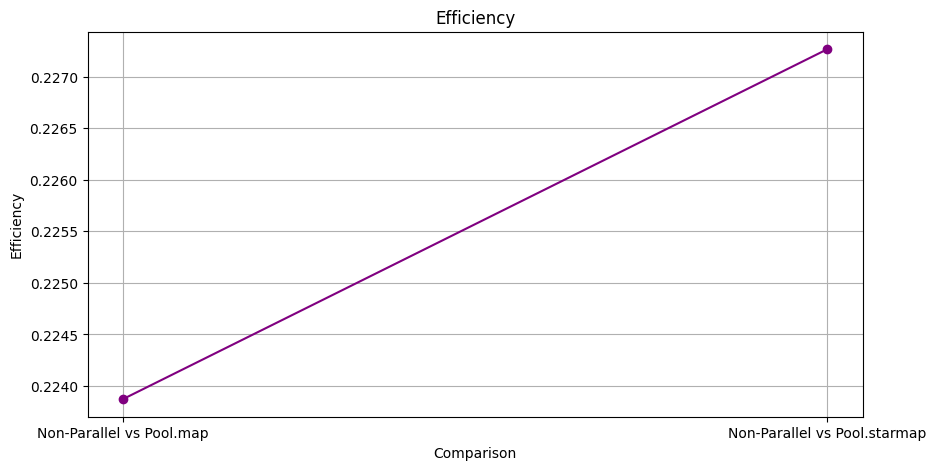

In [10]:
# Create a dictionary with the execution times
times = {'Non-Parallel': execution_time, 'Pool.map': execution_time_map, 'Pool.starmap': execution_time_starmap}

# Plot
plt.bar(times.keys(), times.values())
plt.xlabel('Method')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison')
plt.show()

# Execution times
execution_time_serial = times['Non-Parallel']
execution_time_map = times['Pool.map']
execution_time_starmap = times['Pool.starmap']

# Speedup
speedup_map = execution_time_serial / execution_time_map
speedup_starmap = execution_time_serial / execution_time_starmap

# Efficiency
num_processors = os.cpu_count()
efficiency_map = speedup_map / num_processors
efficiency_starmap = speedup_starmap / num_processors

# Plot speedup
plt.figure(figsize=(10, 5))
methods = ['Non-Parallel vs Pool.map', 'Non-Parallel vs Pool.starmap']
speedups = [speedup_map, speedup_starmap]
plt.plot(methods, speedups, marker='o', color='green')
plt.title('Speedup')
plt.xlabel('Comparison')
plt.ylabel('Speedup')
plt.grid(True)
plt.show()

# Plot efficiency
plt.figure(figsize=(10, 5))
efficiencies = [efficiency_map, efficiency_starmap]
plt.plot(methods, efficiencies, marker='o', color='purple')
plt.title('Efficiency')
plt.xlabel('Comparison')
plt.ylabel('Efficiency')
plt.grid(True)
plt.show()

**Oberservation**

- Both the map and starmap methods of parallel processing significantly reduced the execution time from around 250 seconds (for the non-parallel version) to around 30 seconds. This demonstrates the power of parallel processing when dealing with large datasets.

- The map method had an execution time of 30 seconds, while starmap was slightly higher with 32 seconds. The difference between them is negligible, indicating that both methods are equally efficient for this task.

- However, when we tried to use apply for parallel processing, it was taking longer than the non-parallel version. Given that it was taking more time, we decided to stop the execution midway as it was clear that apply was not an efficient choice for this particular task.

- Efficiency, which is the speedup per processor, was 0.3 for both map and starmap methods, indicating suboptimal use of processors. Despite minor differences in performance, the choice between map and starmap should be guided by the specific requirements of the function.

- In conclusion, both **map and starmap** are excellent choices for this task due to their ability to handle multiple tasks concurrently, leading to a substantial reduction in execution time. The choice between map and starmap would depend on the specific requirements of the function and how we prefer to pass arguments to it. In scenarios where the function is designed to take a single tuple as an argument, map would be a suitable choice. On the other hand, if the function is designed to take multiple arguments separately, starmap would be more appropriate.

## **Visualizing Average duration of the audio files**

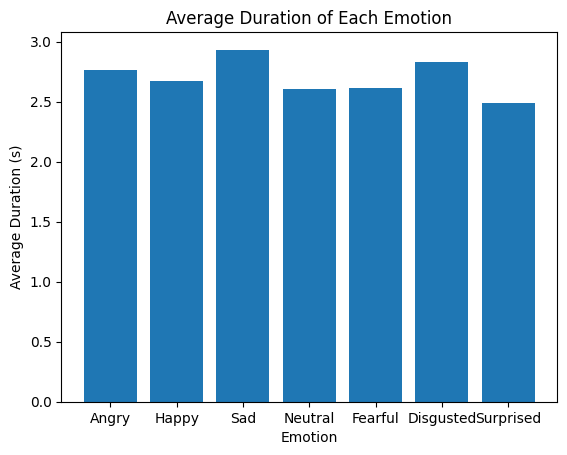

In [11]:
# Plot
plt.bar(average_durations.keys(), average_durations.values())
plt.xlabel('Emotion')
plt.ylabel('Average Duration (s)')
plt.title('Average Duration of Each Emotion')
plt.show()

## **Observation**

- Sad, Disgusted, and Angry emotions have the longest average durations, all hovering around 2.5 seconds. This might suggest that expressions of these emotions naturally take longer to articulate.

- Neutral, Happy and Fearful emotions have slightly shorter average durations, though they are still above 2 seconds, which could indicate that expressions of these emotions are moderately prolonged but not as much as the first three.

- Surprised has the shortest average duration, closer to 2 seconds, implying that neutral expressions are quicker. Disgusted has an average duration that is close to that of Sad and Fearful, which may reflect a moderate length in the expression of this emotion.

- In summary, the graph suggests a trend where more expressive emotions have longer utterances on average, while less expressive or more subdued emotions are associated with shorter utterances. This pattern could be reflective of the natural speech tendencies associated with these emotions.

## 3.6 **Pitch analysis on few of the emotions**

- Pitch analysis is a crucial aspect of audio analysis, especially in emotion recognition. It helps us understand the tonal variations in the audio data associated with different emotions, which can be a significant feature for our model.

### Happy

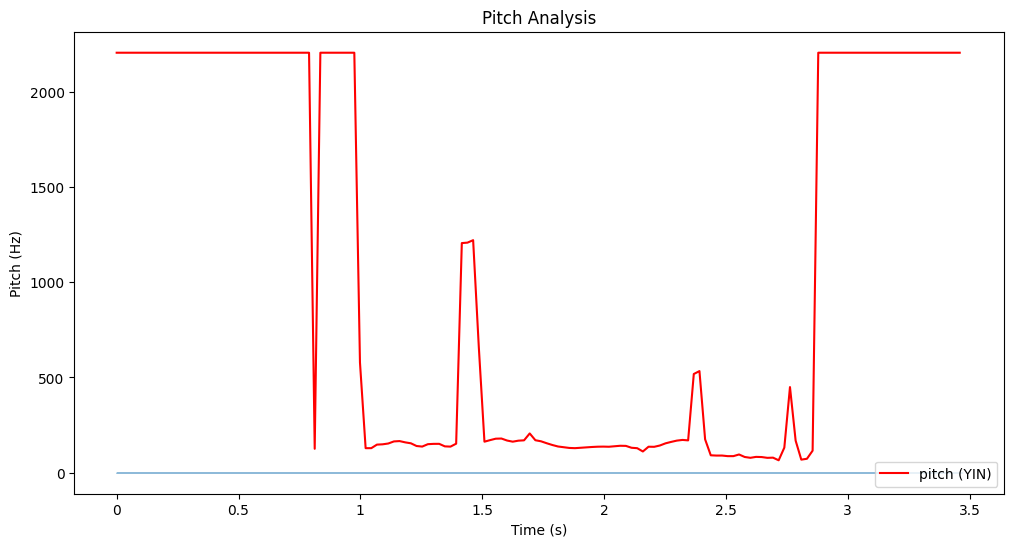

In [12]:
# Load audio file
file_path = '/home/mothakapally.s/Project/data/Emotions/Happy/03-01-03-01-01-01-01.wav'
y, sr = librosa.load(file_path)

# Calculate pitch using the YIN algorithm
f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Plot pitch curve
times = librosa.times_like(f0)
plt.figure(figsize=(12, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(times, f0, label='pitch (YIN)', color='r')
plt.title('Pitch Analysis')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.legend()
plt.show()

**Observation**

- The pitch fluctuates significantly throughout the sample, with several peaks indicating moments of higher pitch.

- There are instances where the pitch reaches very high values, above 2000 Hz, which are likely moments of heightened expressiveness or excitement, which can be associated with happiness.

- The graph displays a pattern of variability with several distinct pitch jumps. This could suggest changes in intonation, which are common in expressing happiness.

- There are periods where the pitch drops to the baseline, which might represent pauses or moments of lower expressiveness within the speech.

- Overall, the pitch analysis graph for the happy emotion reflects a dynamic and varied vocal expression, with significant fluctuations in pitch, consistent with the expressive nature of happiness in speech.

### Sad

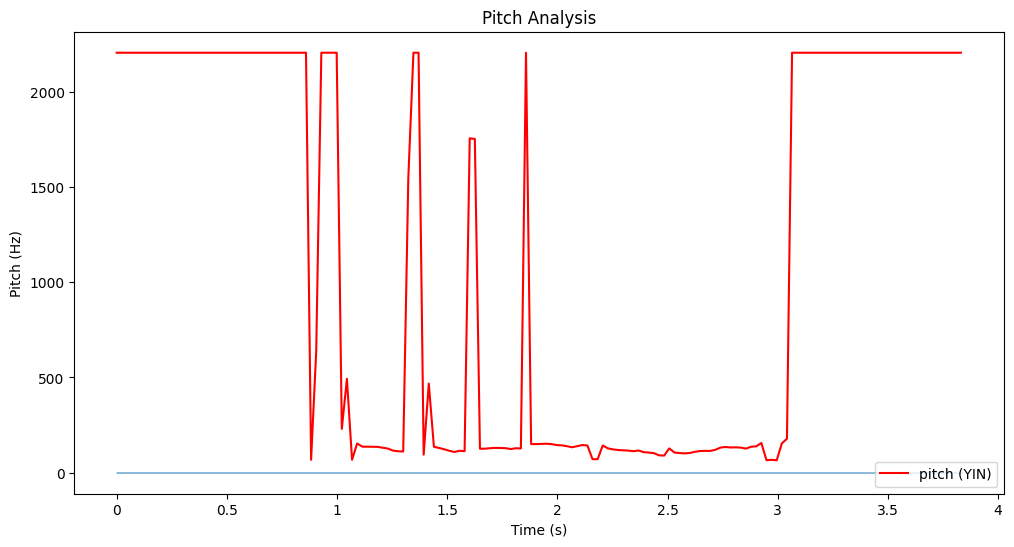

In [13]:
# Load audio file
file_path = '/home/mothakapally.s/Project/data/Emotions/Sad/03-01-04-01-01-01-01.wav'
y, sr = librosa.load(file_path)

# Calculate pitch using the YIN algorithm
f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Plot pitch curve
times = librosa.times_like(f0)
plt.figure(figsize=(12, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.plot(times, f0, label='pitch (YIN)', color='r')
plt.title('Pitch Analysis')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.legend()
plt.show()


**Observation**

- The overall pitch is lower compared to the happy emotion pitch analysis, which is typical as sadness often results in a lower pitch in speech.

- There are still noticeable fluctuations in pitch, but they are less extreme than what you would expect in a happy or excited tone. The fluctuations are also less frequent.

- The pitch shows a tendency to have longer periods at the same frequency, suggesting a more monotonous or flat affect, which is common in sad speech patterns.

- Toward the end of the time scale, there is a significant rise in pitch, which could represent a moment of heightened emotion or a specific expressive element within the sad speech.

- In summary, the sad emotion pitch graph reflects a generally lower pitch and less variability than the happy emotion, aligning with the more subdued and less dynamic nature of sad vocal expressions.

## 3.7 **Waveform visualizations for few of the emotions**

- Waveform visualizations provide a graphical representation of the audio data, allowing us to observe the patterns and variations in the audio signals associated with different emotions. This can be particularly useful in identifying features that might be relevant for emotion recognition.


### Neutral

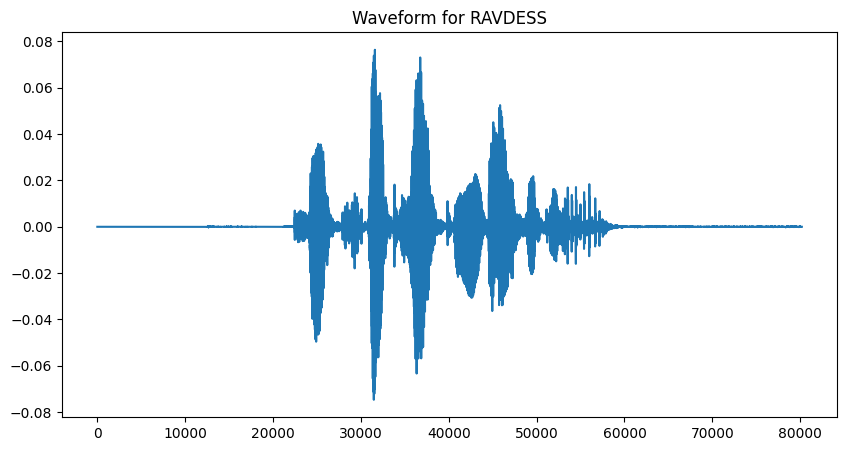

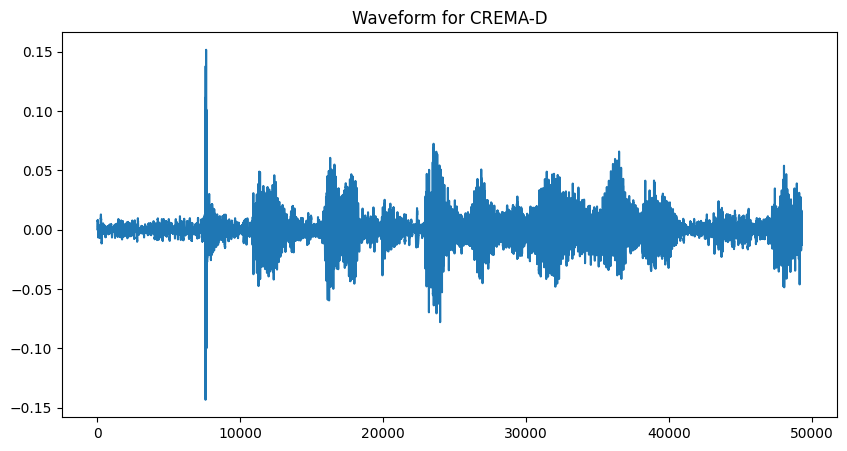

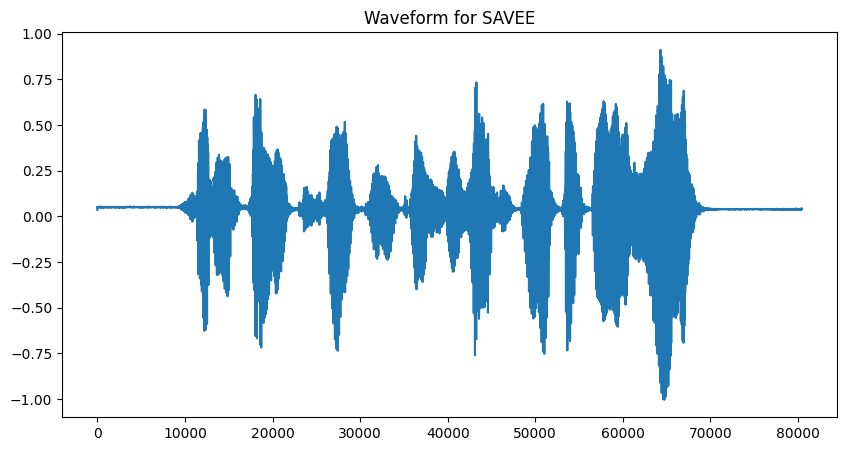

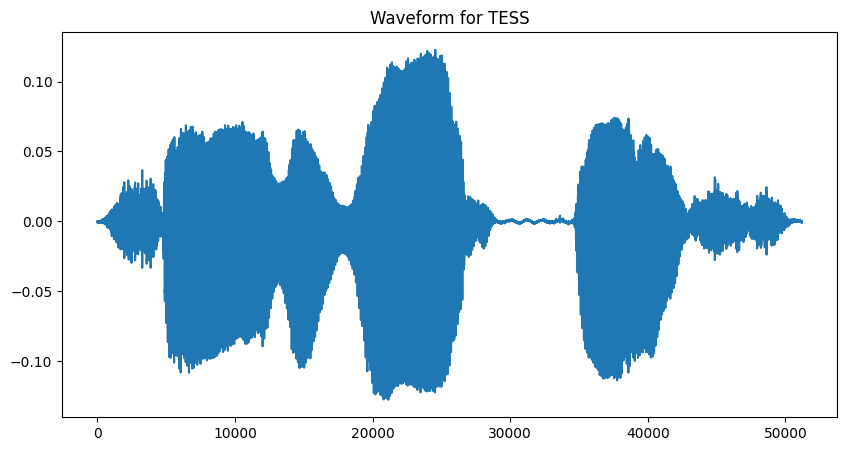

In [14]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Neutral'

# Define the filenames for each dataset
filenames = ['03-01-01-01-01-01-02.wav', '1004_ITS_NEU_XX.wav', 'a01.wav', 'YAF_voice_neutral.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Plot the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(y)
    plt.title(f'Waveform for {labels[i]}')
    plt.show()

**Observation**

- RAVDESS: The waveform indicates a relatively stable and moderate amplitude, which aligns with a neutral emotion that typically lacks extreme variations or intensity in speech.

- CREMA-D: The waveform shows smaller variations in amplitude, suggesting a calm and consistent tone that one might expect from a neutral emotional state.

- SAVEE: Despite representing neutral emotion, the waveform has a wide dynamic range, which is unusual for a neutral tone as it suggests higher expressiveness. This might indicate a different baseline for neutrality in this dataset or a wider tolerance for what is considered neutral.

- TESS: The distinct, large peaks in the TESS waveform suggest clear enunciation and controlled volume, which could be characteristic of a deliberate attempt to maintain a neutral tone.

- Overall, while all samples are labeled as neutral, there's noticeable variability in the expressiveness and dynamic range across the datasets. SAVEE's broader range could imply a different interpretive scale for neutrality, or perhaps more variance within the dataset's samples. In contrast, CREMA-D's limited amplitude variations and TESS's deliberate patterns are more in line with conventional expectations of a neutral emotional delivery. RAVDESS appears to offer a balanced neutral tone with moderate expressiveness.

### Angry

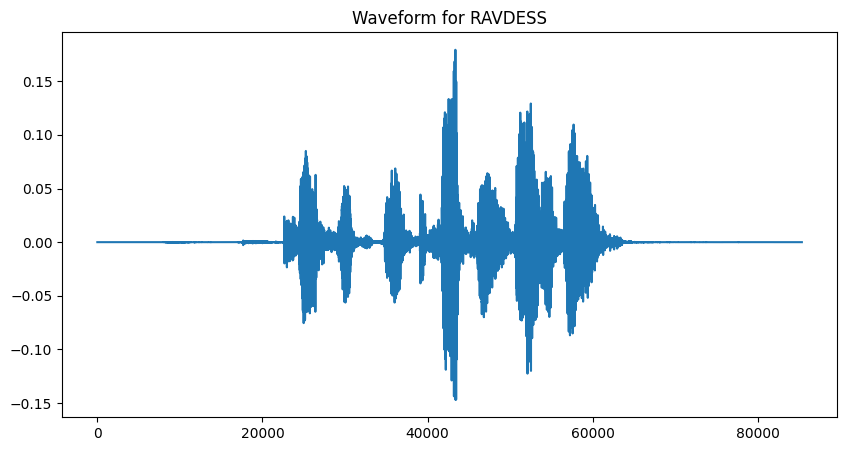

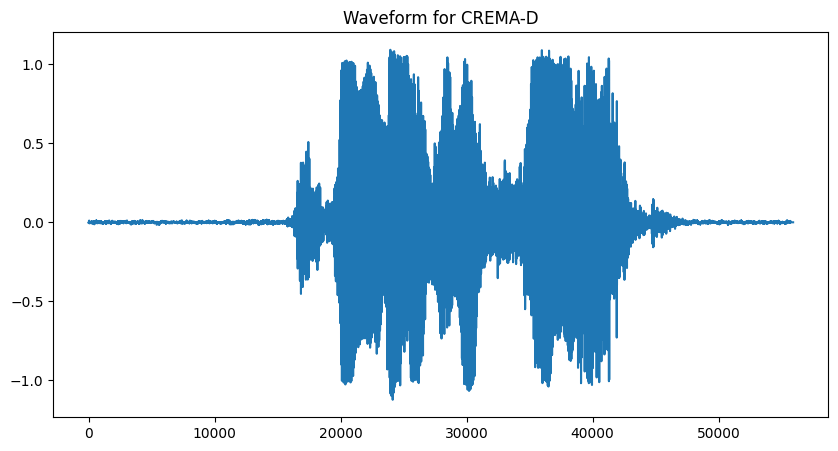

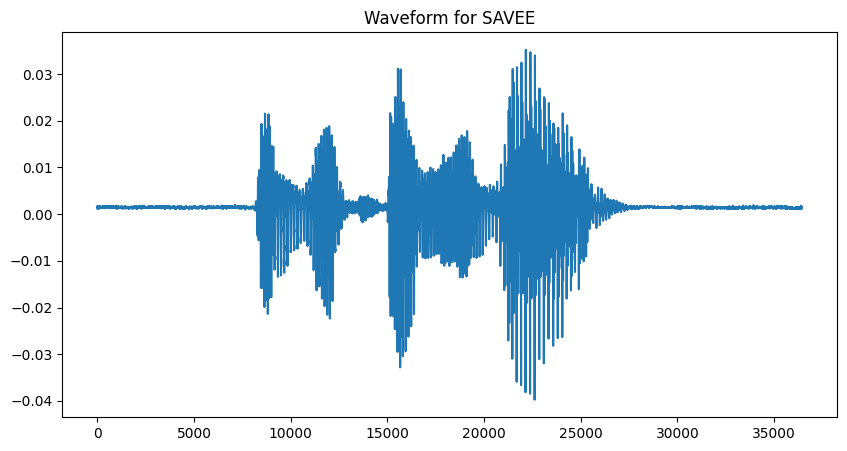

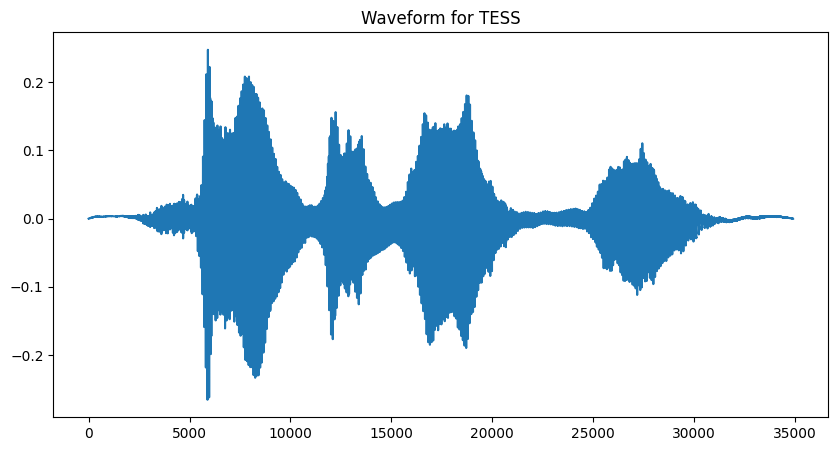

In [15]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Angry'

# Define the filenames for each dataset
filenames = ['03-01-05-01-01-01-01.wav', '1035_IEO_ANG_HI.wav', 'n03.wav', 'OAF_youth_angry.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Plot the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(y)
    plt.title(f'Waveform for {labels[i]}')
    plt.show()

**Observation**

- RAVDESS: The waveform for RAVDESS shows a varied pattern with several peaks, indicating strong fluctuations in volume and intensity, which is characteristic of an angry tone.

- CREMA-D: The CREMA-D waveform displays a very wide dynamic range with high peaks, suggesting loud and possibly aggressive vocal expressions often associated with anger.

- SAVEE: The SAVEE waveform appears to have a more restrained dynamic range compared to CREMA-D. The fluctuations are less extreme but still present, indicating a less intense but clearly expressed anger.

- TESS: The TESS waveform shows pronounced peaks with a moderate dynamic range, suggesting a controlled but clearly articulated angry tone.

- In comparison, the CREMA-D dataset seems to depict the most intense expression of anger, with the highest amplitude peaks. RAVDESS and TESS appear to convey anger with a moderate level of expressiveness, and SAVEE shows a more contained expression. Each dataset might have different thresholds for the expression of anger, leading to these variations in waveform patterns.

### Happy

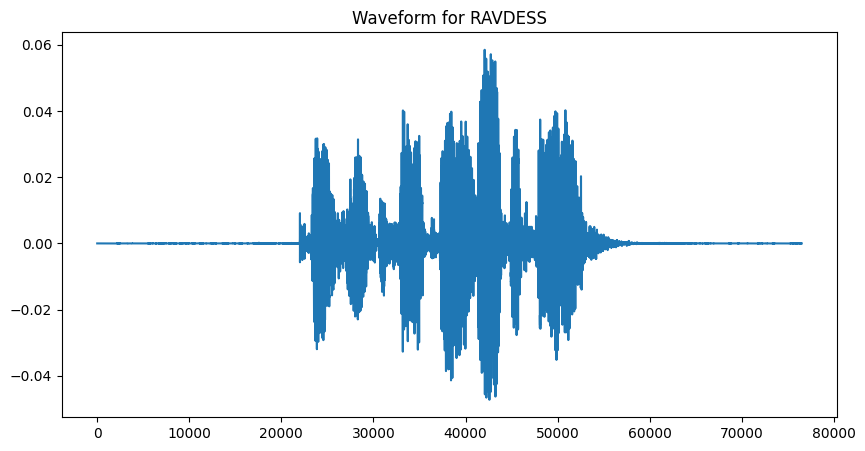

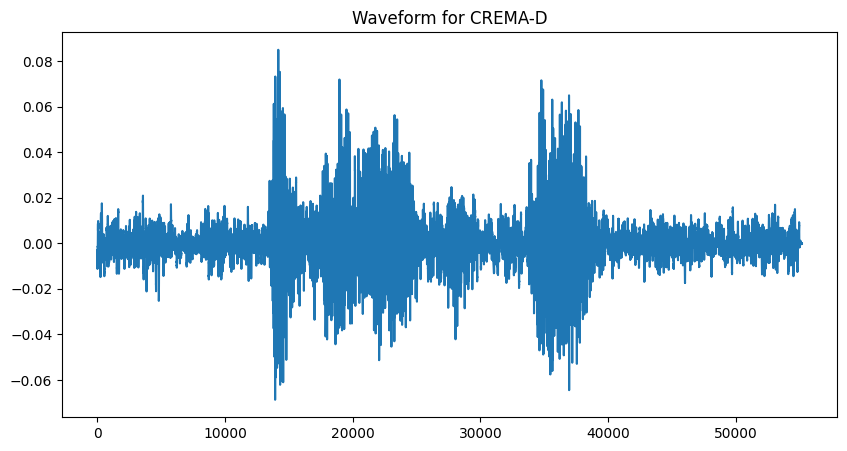

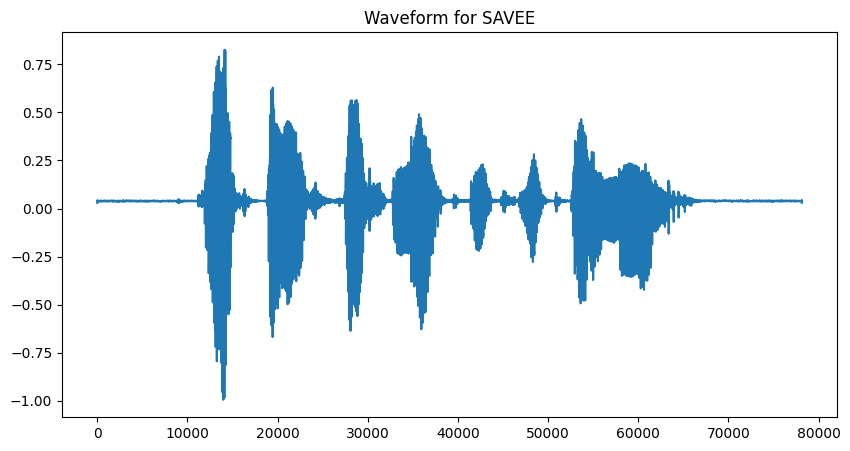

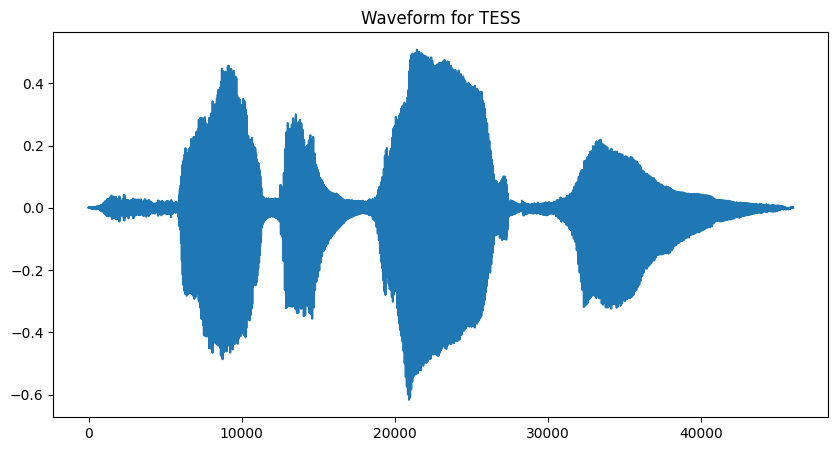

In [16]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Happy'

# Define the filenames for each dataset
filenames = ['03-01-03-01-01-01-01.wav', '1021_IEO_HAP_MD.wav', 'n08.wav', 'YAF_yearn_happy.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Plot the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(y)
    plt.title(f'Waveform for {labels[i]}')
    plt.show()

**Observation**

- RAVDESS: The waveform exhibits a dynamic pattern with regular fluctuations in amplitude. This is typical for happy expressions in speech, which can vary in pitch and intensity due to the more animated nature of the emotion.

- CREMA-D: This waveform shows a somewhat erratic pattern with sharp peaks and a considerable dynamic range. The variability suggests a lively expression of happiness, which may include laughter or excited speech.

- SAVEE: The SAVEE waveform displays a very broad dynamic range with deep valleys and high peaks. This indicates a robust and energetic expression of happiness, possibly with loud and clear articulation.

- TESS: The TESS waveform has a very pronounced and symmetrical shape, with wide peaks that suggest sustained, expressive vocalizations typical of a happy tone.

- In summary, the waveforms from all datasets show variability in amplitude, which is consistent with vocal expressions of happiness that often involve changes in pitch and loudness. The SAVEE dataset seems to depict the most vigorous expression of happiness, with the widest range in amplitude. CREMA-D also indicates a high level of expressiveness, whereas RAVDESS and TESS suggest a more moderate but still clear expression of happiness. Each dataset's waveform pattern reflects different aspects of happy speech tones, from lively and energetic to cheerful and sustained.

### Sad

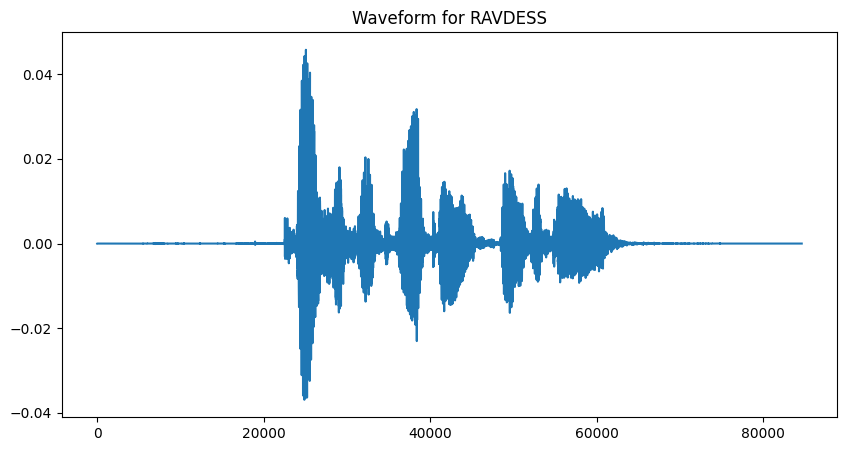

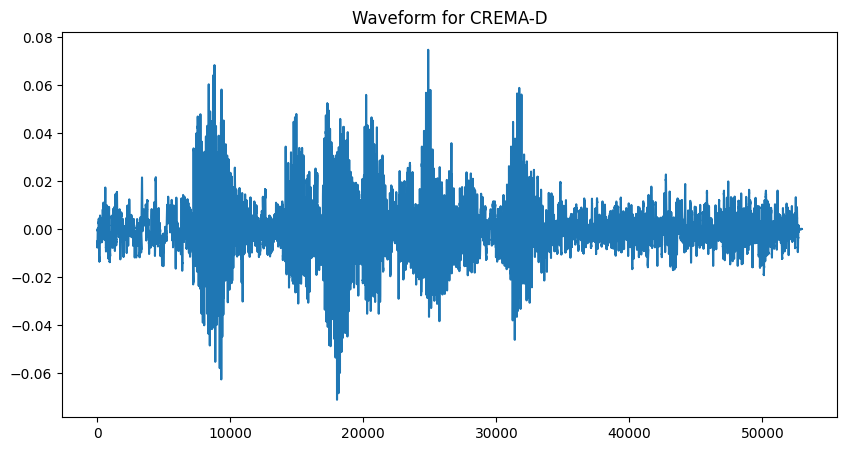

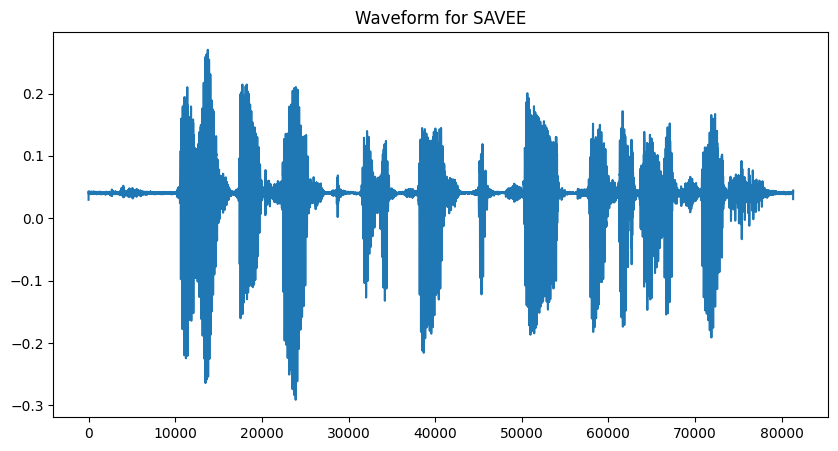

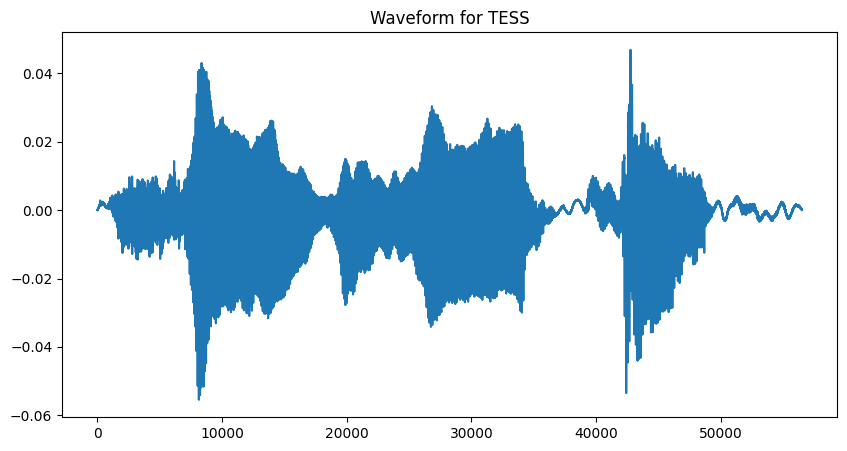

In [17]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Sad'

# Define the filenames for each dataset
filenames = ['03-01-04-01-01-01-01.wav', '1020_DFA_SAD_XX.wav', 'n30.wav', 'OAF_back_sad.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Plot the waveform
    plt.figure(figsize=(10, 5))
    plt.plot(y)
    plt.title(f'Waveform for {labels[i]}')
    plt.show()

**Observation**

- RAVDESS: The RAVDESS waveform shows fluctuations with moderate amplitudes and a smooth decline towards the end. The variations in amplitude are less extreme, which might reflect the subdued nature of sadness in vocal expressions.

- CREMA-D: The CREMA-D waveform displays a slightly erratic pattern with a mix of higher and lower peaks, suggesting variability in the vocal expression of sadness, possibly including moments of more pronounced vocal stress.

- SAVEE: The SAVEE waveform has a consistent pattern of peaks and valleys with a significant dynamic range. This could indicate a more expressive or dramatic representation of sadness within this dataset.

- TESS: The TESS waveform features broad peaks and troughs, which implies a clear and sustained expression of sadness. The waveform suggests a controlled and consistent sad tone, possibly with prolonged vowel sounds which are typical for sad speech.

- In comparison, while all datasets show variability appropriate for the expression of sadness, SAVEE's waveform suggests a more intense or expressive sadness, and CREMA-D shows some level of expressiveness. RAVDESS and TESS appear to convey a more restrained expression of sadness, with RAVDESS showing a smoother pattern and TESS exhibiting more controlled fluctuations. The sad emotion is generally characterized by lower pitch and less variation in intensity, which seems to be reflected across these datasets with some individual variations.

## 3.8 **Power Spectrums Visualizations by Performing Fourier Transformations**

- Visualizing the power spectrum of audio data provides insights into the frequency components of the audio signals for different emotions. By performing Fourier transformations, we can convert the audio signals from the time domain to the frequency domain, making it easier to analyze the frequency characteristics. This can be particularly useful in identifying features that might be relevant for emotion recognition.

### lets plot this for few of the emotions

### Disgusted

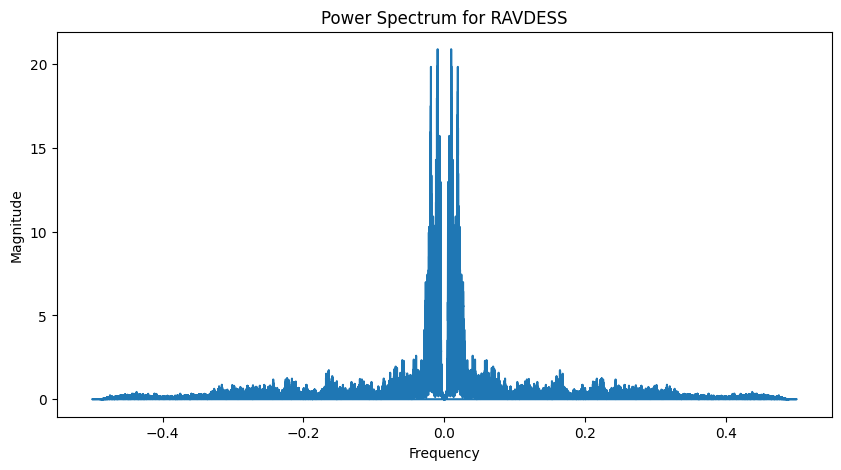

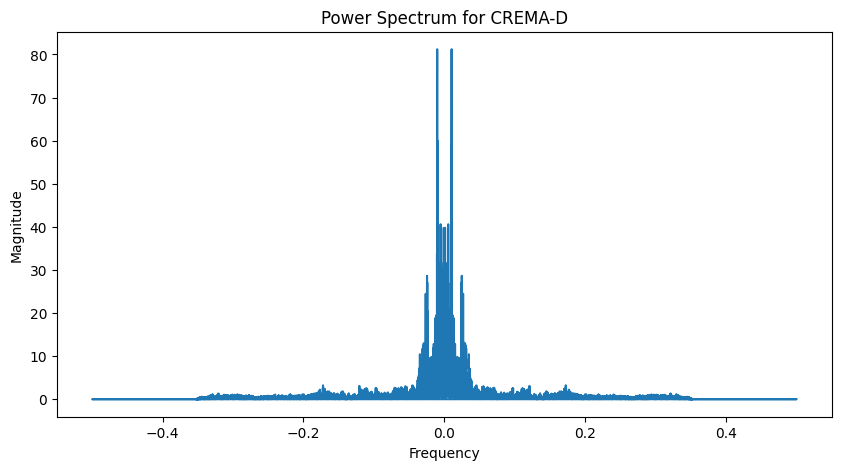

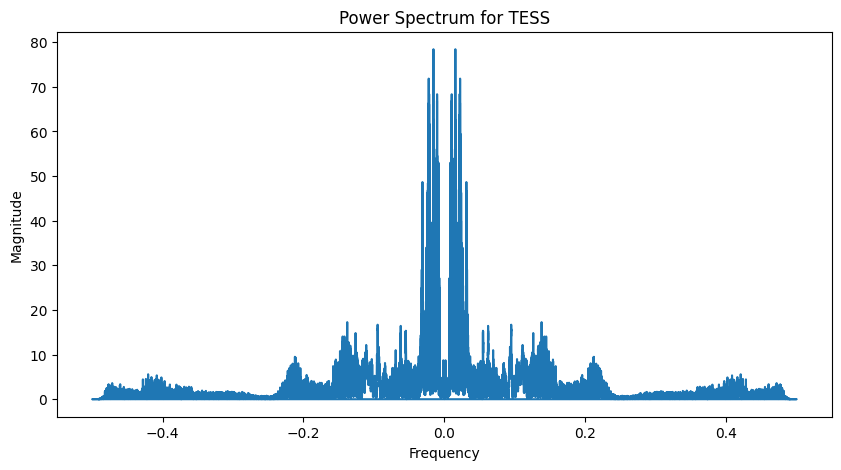

In [18]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Disgusted'

# Define the filenames for each dataset
filenames = ['03-01-07-01-01-01-01.wav', '1011_ITH_DIS_XX.wav', 'YAF_week_disgust.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Perform the Fourier transformation
    fft = np.fft.fft(y)

    # Calculate the power spectrum
    spectrum = np.abs(fft)

    # Create an array of frequencies
    freq = np.fft.fftfreq(len(spectrum))

    # Plot the power spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freq, spectrum)
    plt.title(f'Power Spectrum for {labels[i]}')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.show()

**Observation**

- RAVDESS: The spectrum shows a central frequency peak with less magnitude compared to the others. This indicates a focused frequency range, which might reflect the tonal quality of disgusted expressions in this dataset, possibly suggesting less intensity or a more subdued expression of disgust.

- CREMA-D: This dataset's spectrum has the highest peak, indicating a strong fundamental frequency and suggesting that the disgusted emotion in CREMA-D is expressed with a dominant pitch and possibly higher energy or intensity.

- TESS: The spectrum has a central peak and additional peaks, suggesting a more complex frequency distribution. This complexity could indicate a richer or more varied expression of disgust, with more nuanced tonal variations or inflections.

- The comparison shows that CREMA-D recordings may contain the most intense or forceful expressions of disgust, given the high magnitude of the central peak. In contrast, RAVDESS might represent a more restrained expression, and TESS seems to have the most complex tonal expression of disgust. These variations could reflect differences in how speakers express disgust, recording techniques, or the intended use of each dataset.

### fearful

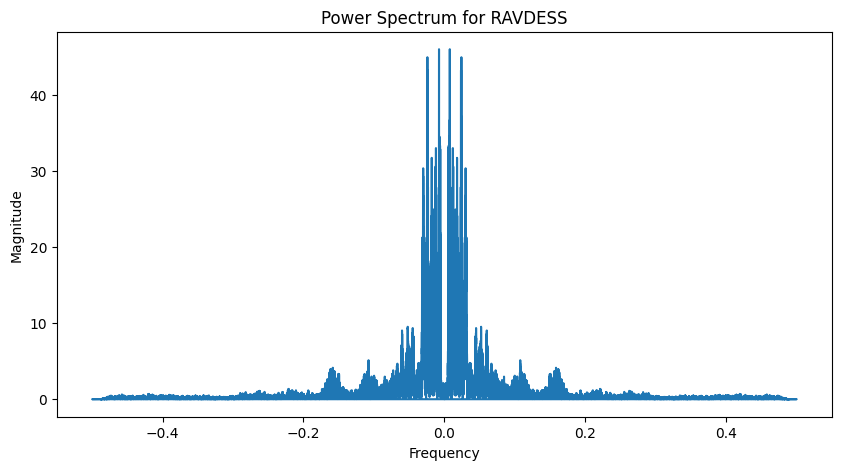

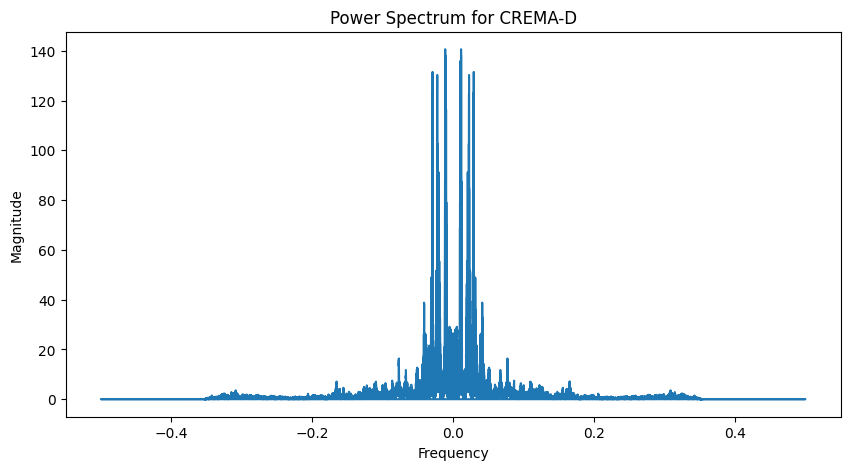

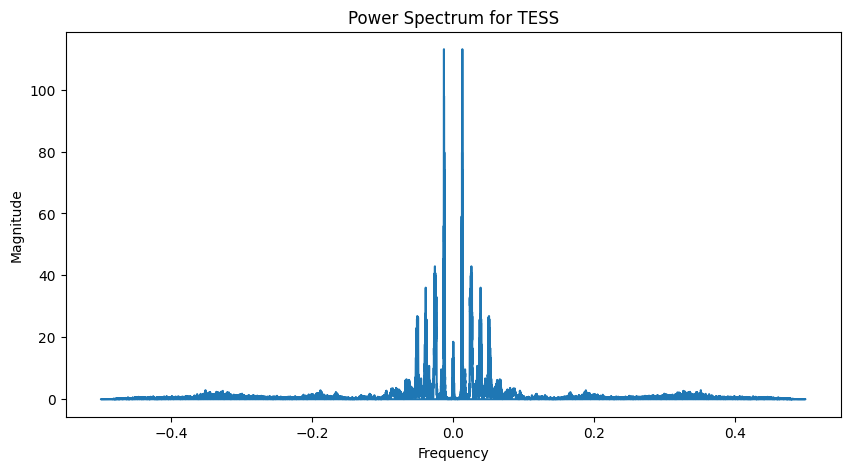

In [19]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Fearful'

# Define the filenames for each dataset
filenames = ['03-01-06-01-01-01-01.wav', '1012_TAI_FEA_XX.wav', 'OAF_lot_fear.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Perform the Fourier transformation
    fft = np.fft.fft(y)

    # Calculate the power spectrum
    spectrum = np.abs(fft)

    # Create an array of frequencies
    freq = np.fft.fftfreq(len(spectrum))

    # Plot the power spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freq, spectrum)
    plt.title(f'Power Spectrum for {labels[i]}')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.show()

**Observation**

- RAVDESS: The power spectrum shows several peaks concentrated around the central frequencies with a high magnitude, suggesting a dominant frequency with significant harmonics. This pattern may represent the variations in pitch and volume typically associated with a fearful voice.

- CREMA-D: The spectrum for CREMA-D exhibits an even higher central peak than RAVDESS, indicating a very strong fundamental frequency and harmonics, which could correspond to a particularly intense or expressive fear vocalization in this dataset.

- TESS: The TESS spectrum also shows a central peak but with multiple surrounding peaks, indicating a variety of frequency components. This suggests a complex sound with multiple frequency variations, which might reflect a nuanced expression of fear with various intonations.

- In summary, all three spectra indicate the presence of strong fundamental frequencies and harmonics, which are characteristic of the fearful emotion's vocal expression. However, the CREMA-D dataset displays the highest magnitude, suggesting the strongest expression of fear among the three. RAVDESS and TESS have lower magnitudes but still show a clear presence of harmonics, with TESS indicating more complexity in the frequency domain.

## 3.9 **Spectrogram Visualizations**

- Spectrogram visualizations are a powerful tool for analyzing audio data. They provide a 2D representation of the frequency content of an audio signal as it changes over time. By visualizing spectrograms for different emotions, we can gain insights into the frequency patterns associated with each emotion. This can help us identify unique features for each emotion, which can be useful in building our emotion recognition model.

### Neutral

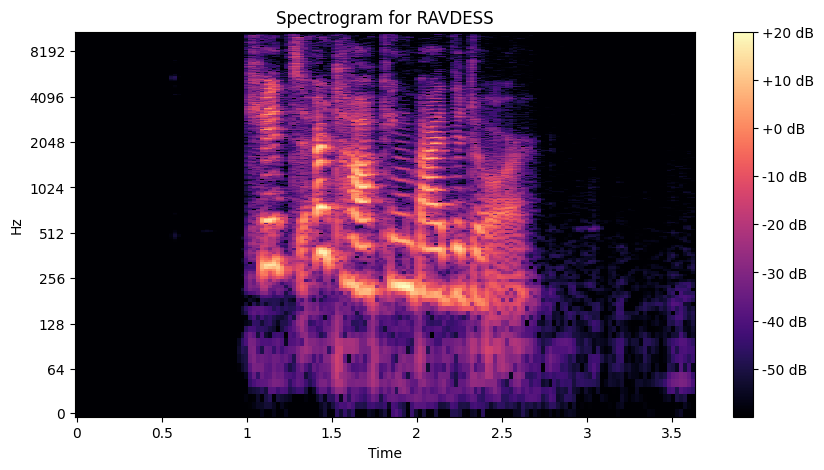

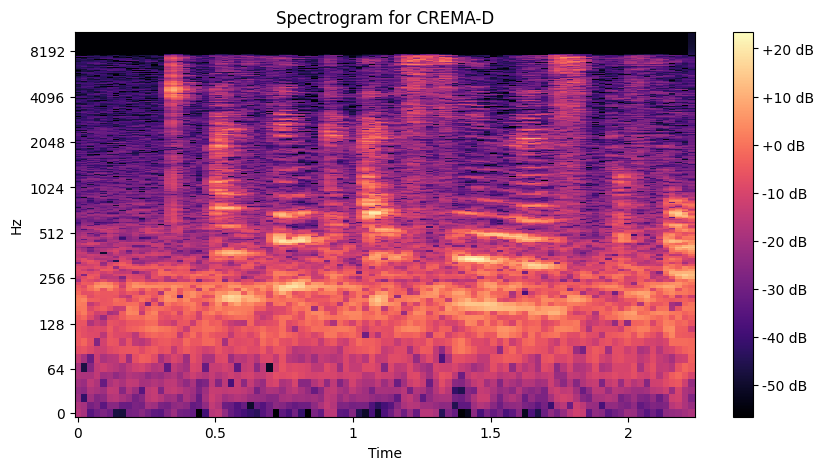

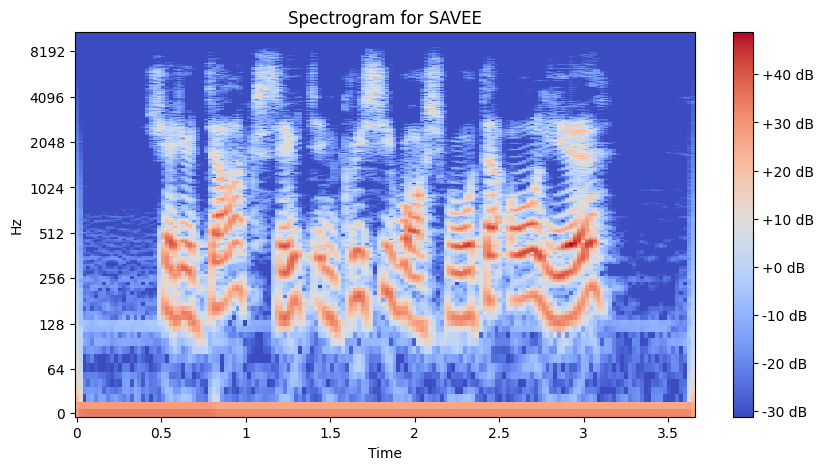

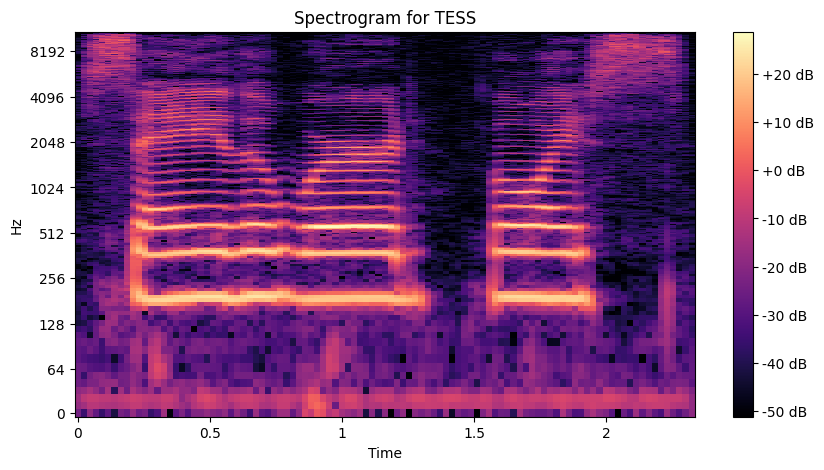

In [20]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Neutral'

# Define the filenames for each dataset
filenames = ['03-01-01-01-01-01-02.wav', '1004_ITS_NEU_XX.wav', 'a01.wav', 'YAF_voice_neutral.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Calculate the STFT
    D = librosa.stft(y)

    # Convert the amplitude to decibels
    db = librosa.amplitude_to_db(abs(D))

    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram for {labels[i]}')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

**Observation**

- RAVDESS: This spectrogram shows a concentration of energy at certain frequencies, which is indicated by the brighter areas. There is a wide range of frequencies present with variability over time, which suggests variation in the vocalizations even within the neutral state.

- CREMA-D: The spectrogram of CREMA-D has less clear definition in the frequency bands, with a more diffused energy distribution across frequencies. The energy seems to be spread over a broader frequency range without distinct bright lines, which might indicate a more uniform tone typical of a neutral emotional state.

- SAVEE: The SAVEE spectrogram has distinct bands of energy at specific frequencies that are consistent over time, showing less variability in frequency content. The regular pattern of bright lines suggests a controlled and steady vocal expression.

- TESS: The TESS spectrogram displays very defined and consistent horizontal bands of energy, indicating strong harmonic content. The clear, bright lines at specific frequencies suggest a regular and patterned vocal expression, which is likely indicative of a calm and consistent speech pattern associated with a neutral tone.

- In brief, the RAVDESS and CREMA-D spectrograms show more frequency variability, which could reflect subtle nuances or natural fluctuations in speech, even in a neutral tone. In contrast, SAVEE and TESS show more defined frequency bands, suggesting a more consistent or controlled tone in the neutral vocal expression. The variability between these spectrograms could result from differences in recording conditions, speaker articulation, and dataset-specific characteristics.

## Happy

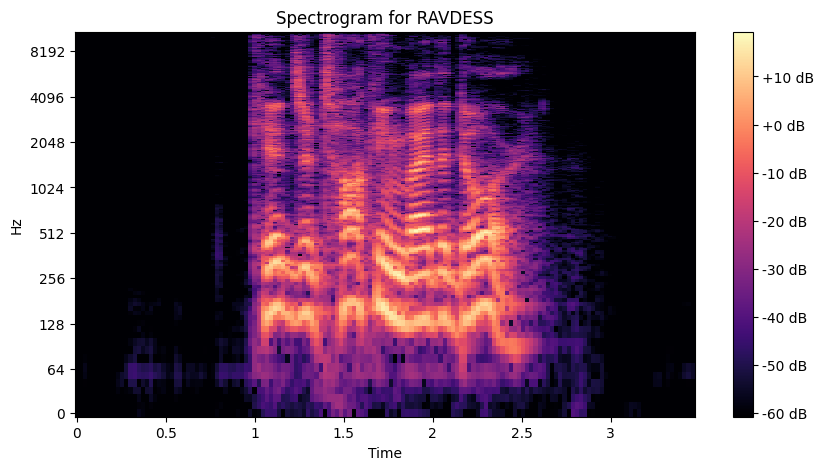

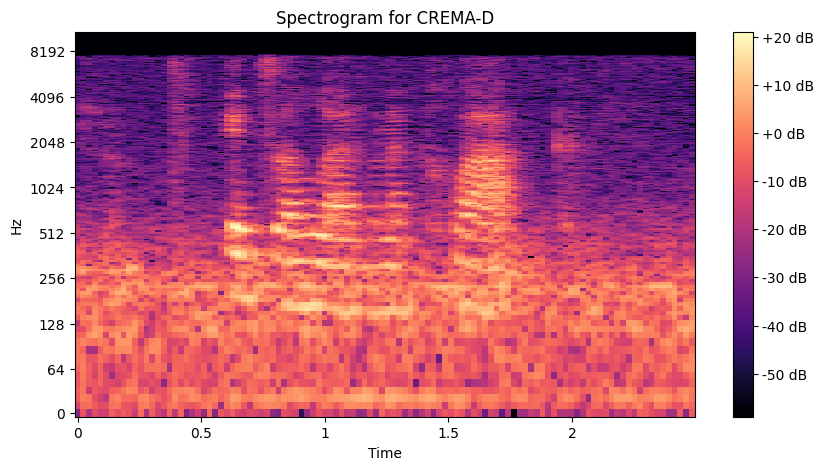

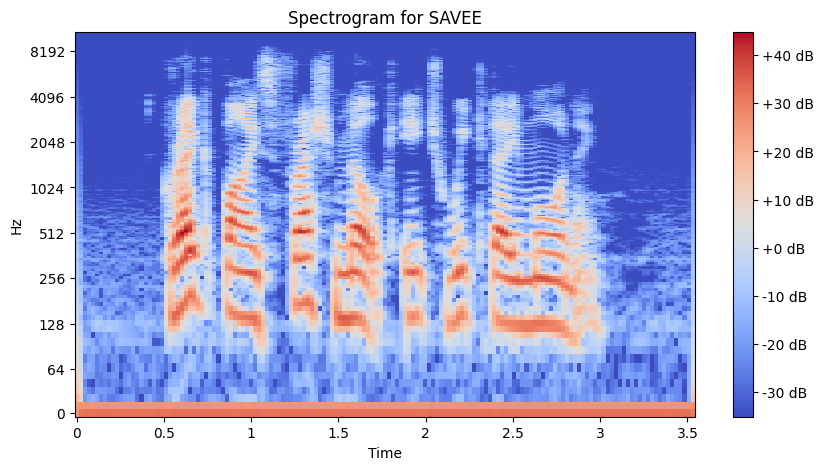

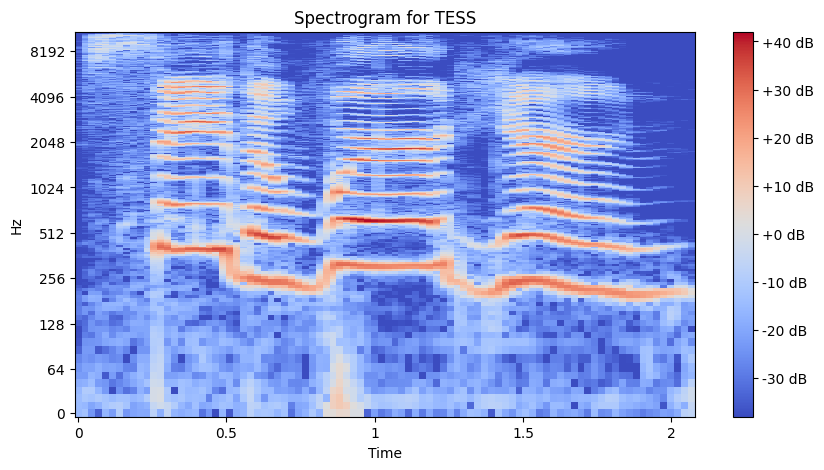

In [21]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Happy'

# Define the filenames for each dataset
filenames = ['03-01-03-01-01-01-01.wav', '1021_IEO_HAP_MD.wav', 'n08.wav', 'YAF_yearn_happy.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Calculate the STFT
    D = librosa.stft(y)

    # Convert the amplitude to decibels
    db = librosa.amplitude_to_db(abs(D))

    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram for {labels[i]}')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

**Observation**

- RAVDESS: The RAVDESS spectrogram displays a broad range of frequencies with several bright areas, suggesting the presence of both low and high frequencies. The variability over time with multiple harmonics could indicate a lively and varied expression of happiness.

- CREMA-D: This spectrogram shows a more uniform distribution of energy across the frequency spectrum but with less distinction in the harmonics compared to RAVDESS. The energy is more diffused, which might suggest a less dynamic or less intense happy expression.

- SAVEE: The SAVEE spectrogram has clear, bright bands of energy indicating strong harmonics, and these bands are quite regular over time. This pattern can be associated with a rhythmic and expressive speech, which is often seen in happy vocalizations.

- TESS: Similar to SAVEE, the TESS spectrogram also shows well-defined harmonic bands. The consistency of these bands suggests a clear and possibly more controlled expression of happiness, perhaps with a musical or sing-song quality.

- Comparing all four, RAVDESS and SAVEE exhibit more complex patterns, potentially indicating a richer or more variable expression of happiness. CREMA-D shows a smoother distribution, which could reflect a calmer happiness, while TESS, with its consistent bands, might indicate a happy tone that's steady and possibly more melodious. These differences may reflect variations in the actors' performances, recording techniques, or intended use of the datasets.

### Sad

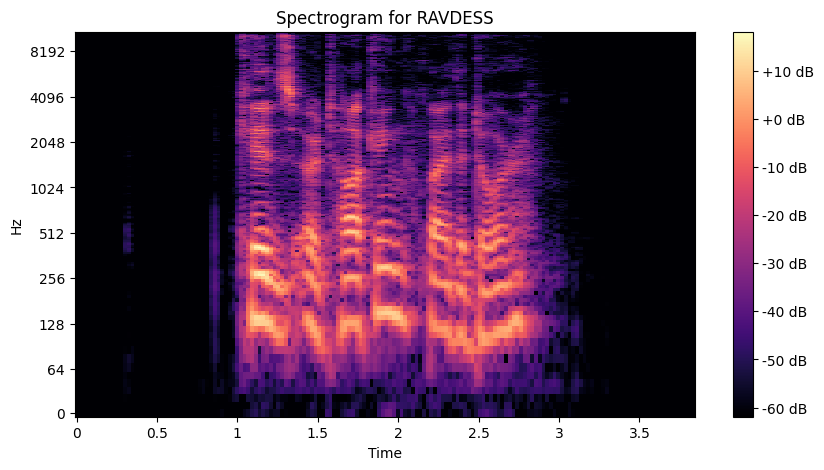

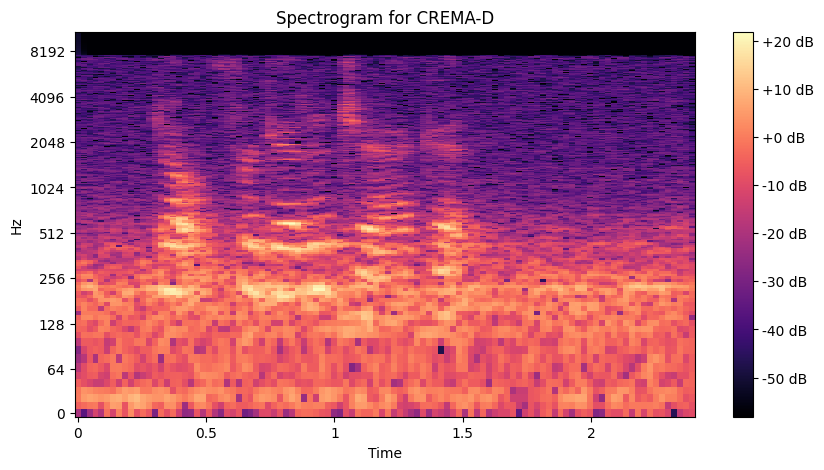

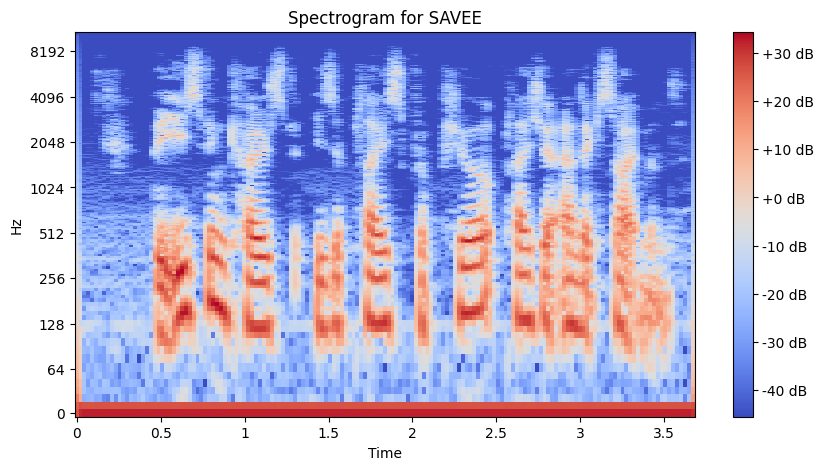

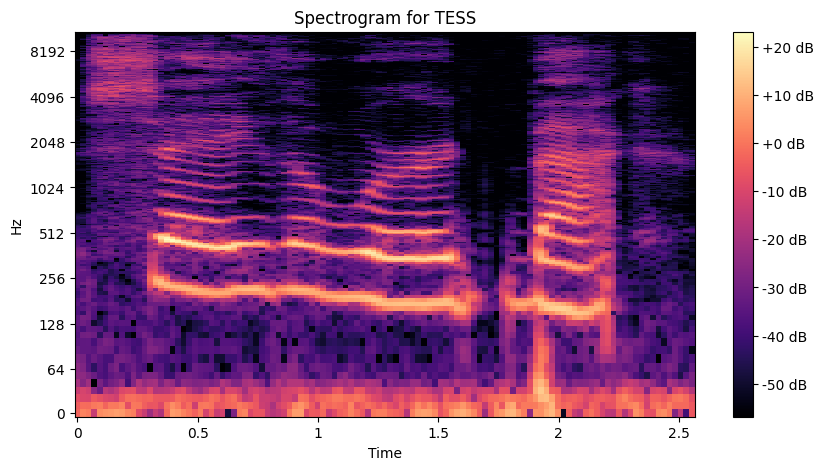

In [22]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions/Sad'

# Define the filenames for each dataset
filenames = ['03-01-04-01-01-01-01.wav', '1020_DFA_SAD_XX.wav', 'n30.wav', 'OAF_back_sad.wav']

# Define the labels for each dataset
labels = ['RAVDESS', 'CREMA-D', 'SAVEE', 'TESS']

# Loop over the filenames
for i, filename in enumerate(filenames):
    # Load the audio file
    y, sr = librosa.load(os.path.join(directory, filename))

    # Calculate the STFT
    D = librosa.stft(y)

    # Convert the amplitude to decibels
    db = librosa.amplitude_to_db(abs(D))

    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram for {labels[i]}')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

**Observation**

- RAVDESS: This spectrogram shows a wide range of frequencies with significant energy in the mid-frequency range. The distribution is quite dynamic, with changes over time, which could indicate a variable vocal expression associated with sadness.

- CREMA-D: The CREMA-D spectrogram appears more uniform with less pronounced energy in the higher frequencies. The lower and mid-frequencies are more represented, which could suggest a subdued or mellow expression of sadness, often characterized by a reduction in vocal energy.

- SAVEE: The SAVEE spectrogram has distinctive and regular energy bands across the frequencies, with clear harmonics visible. This may reflect a consistent or controlled expression of sadness, possibly with a pattern of rising and falling inflections that are typical for sad speech.

- TESS: The TESS spectrogram presents clear and consistent horizontal bands of energy, indicating strong harmonics. The lower frequencies have prominent energy, and the pattern is quite regular, which might suggest a controlled and steady sad tone, possibly with sustained vowel sounds.

- In summary, RAVDESS shows the most variability in energy distribution, indicating a more dynamic expression of sadness. CREMA-D suggests a more level and subdued tone, while SAVEE and TESS display clear harmonic structures, indicating a patterned or consistent expression of sadness. Each dataset's spectrogram reflects different vocal characteristics that may relate to the actors' performance styles, recording techniques, or the intended emotional intensity of the dataset.

## 3.10 **MFCC Visualizations**

- Mel Frequency Cepstral Coefficients (MFCCs) are a type of feature widely used in speech and audio processing. They provide a representation of the power spectrum of an audio signal, specifically designed to mimic the human auditory system. Visualizing MFCCs can help us understand the characteristics of different emotions in the frequency domain. This can be particularly useful in identifying features that might be relevant for emotion recognition.


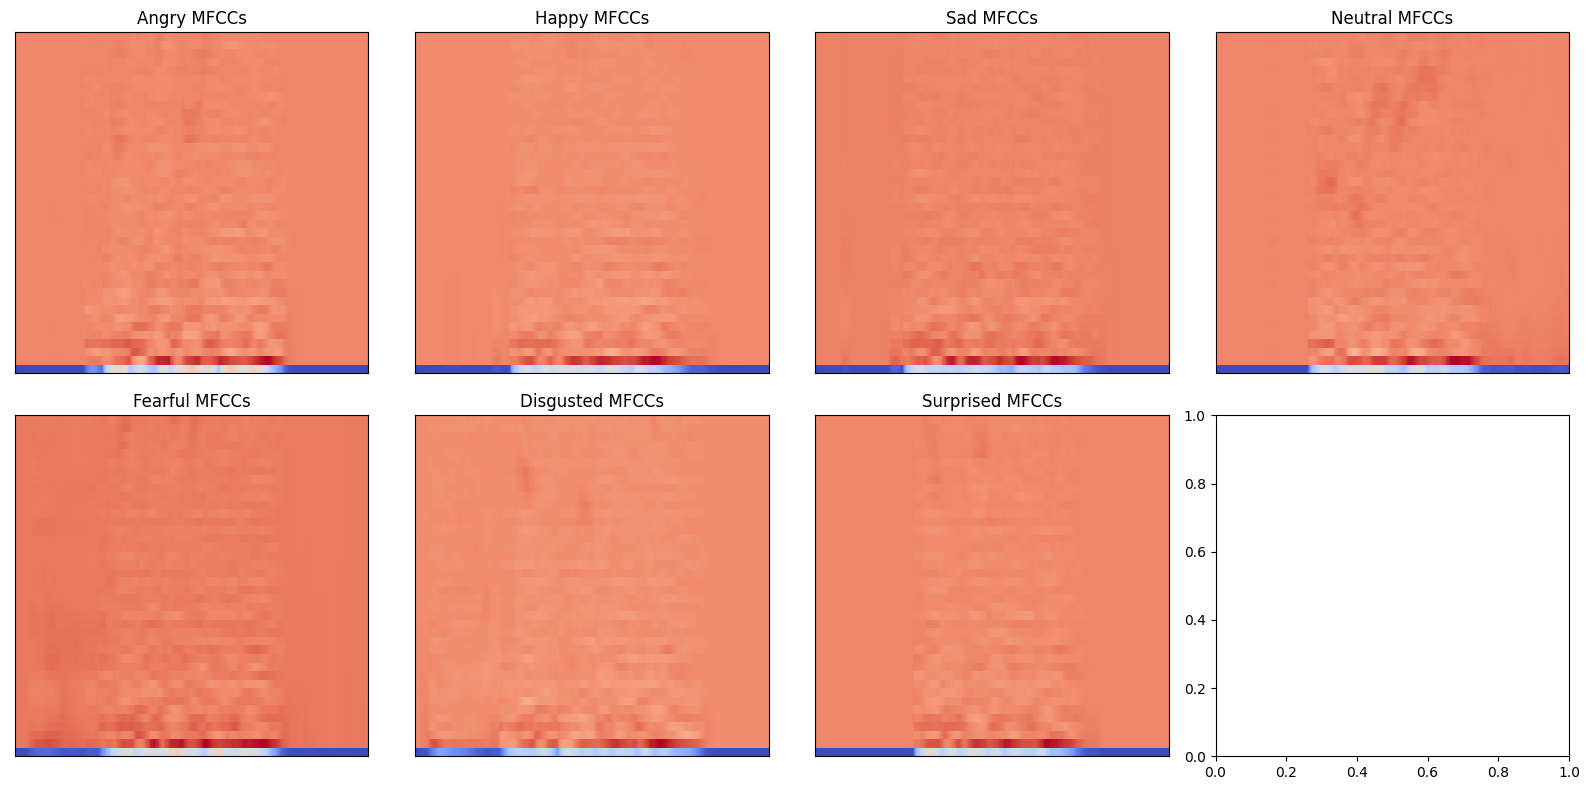

In [23]:
# Define the directory where the 'Neutral' data is stored
directory = '/home/mothakapally.s/Project/data/Emotions'

# Define the emotions and corresponding file names
emotion_files = {
    'Angry': '03-01-05-01-01-01-01.wav',
    'Happy': '03-01-03-01-01-01-01.wav',
    'Sad': '03-01-04-01-01-01-01.wav',
    'Neutral': '03-01-01-01-01-01-02.wav',
    'Fearful': '03-01-06-01-01-01-01.wav',
    'Disgusted': '03-01-07-01-01-01-01.wav',
    'Surprised': '03-01-08-01-01-01-01.wav'
}

# Initialize a dictionary to hold the MFCCs for each emotion
mfccs = {}

# Calculate MFCCs for each emotion
for emotion, file_name in emotion_files.items():
    # Load a sample audio file from each emotion category
    file_path = os.path.join(directory, emotion, file_name)
    signal, sample_rate = librosa.load(file_path, sr=22050)
    
    # Extract 40 MFCCs
    mfccs[emotion] = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)

# Display MFCCs
fig, axs = plt.subplots(2, 4, figsize=(16,8))

for ax, emotion in zip(axs.flatten(), emotion_files.keys()):
    librosa.display.specshow(mfccs[emotion], sr=sample_rate, hop_length=256, ax=ax)
    ax.set_title(f'{emotion} MFCCs')

plt.tight_layout()
plt.show()

**Observation**

- Angry MFCCs: The representation shows variability across the coefficients, indicating dynamic changes in the frequency spectrum, which could correspond to the intensity and high energy typically found in angry speech.

- Happy MFCCs: This also shows variability, but with a slightly different pattern than anger, possibly reflecting the varied intonation that often characterizes happy speech.

- Sad MFCCs: The coefficients here appear to have less contrast compared to angry and happy emotions, which could suggest a narrower frequency range, a common trait in sad vocal expressions where the voice might be more monotone and subdued.

- Neutral MFCCs: The distribution is more uniform and less defined, indicative of a flatter affect and steadier pitch which is expected in a neutral tone.

- Fearful MFCCs: The pattern is somewhat similar to that of anger, possibly reflecting the high energy and possible pitch variations that can accompany a fearful tone.

- Disgusted MFCCs: There seems to be less clarity in the coefficients, which might correspond to a more constrained vocal expression, often associated with disgust.

- Surprised MFCCs: These coefficients show a distinct pattern, potentially indicating the varied intonations and sudden shifts in pitch that can accompany expressions of surprise.

- Each set of MFCCs displays unique characteristics that reflect the acoustic properties of the corresponding emotion. The degree of variability and definition in the MFCCs can give insight into the complexity, intensity, and dynamism of the vocal expression for each emotion.

# 4. **Data preprocessing**

- Data preprocessing is a critical step in any machine learning/Deep Learning project. It involves cleaning and transforming raw data into a format that can be easily understood and used by the algorithms.

- In the context of our project, data preprocessing will involve several steps:

## 4.1 **Check and Remove Bias**
- We'll start by checking for any biases in our dataset, such as class imbalance, and take steps to mitigate them. This is crucial to ensure our model doesn't become biased towards certain emotions.

- Remove bias - as Surprised data is compartively less, we will perform **data augmentation**

In [24]:
# # Define the directory where the 'Surprised' data is stored
# directory = '/home/mothakapally.s/Project/data/Emotions/Surprised'

# # Get the list of 'Surprised' audio files
# files = os.listdir(directory)

# # Define the number of augmented files you want to create per original file
# n_augmented_files = 3

# # Measure execution time
# start_time = time.time()

# # Loop over the files
# for file in files:
#     # Load the audio file
#     y, sr = librosa.load(os.path.join(directory, file))

#     # Loop to create augmented files
#     for i in range(n_augmented_files):
#         # Change the pitch
#         y_changed_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-2, 3))

#         # Save the augmented audio file
#         sf.write(os.path.join(directory, f'{file[:-4]}_augmented_{i}.wav'), y_changed_pitch, sr)

# end_time = time.time()

# # Calculate and print execution time
# execution_time = end_time - start_time
# print(f'Total execution time: {execution_time} seconds')

**Observation**
- This task took a lot of time to execute
- We had to **comment it** and re download the original dataset in order to parallelize this task to reduce execution time
- Hence it is not possible to execute both non-parallel and parallel version of this task as the dataset gets augmented

## Lets try to parallelize this using **concurrent.futures**

- concurrent.futures and ThreadPoolExecutor are Python modules used to perform parallel execution of tasks, such as augmenting audio data in an imbalanced dataset, by leveraging multiple threads to improve efficiency.

In [25]:
def augment_audio(file):
    # Load the audio file
    y, sr = librosa.load(file)

    # Loop to create augmented files
    for i in range(n_augmented_files):
        # Change the pitch
        y_changed_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.randint(-2, 3))

        # Save the augmented audio file
        sf.write(f'{file[:-4]}_augmented_{i}.wav', y_changed_pitch, sr)

if __name__ == "__main__":
    # Define the directory where the 'Surprised' data is stored
    directory = '/home/mothakapally.s/Project/data/Emotions/Surprised'

    # Get the list of 'Surprised' audio files
    files = [os.path.join(directory, file) for file in os.listdir(directory)]

    # Define the number of augmented files you want to create per original file
    n_augmented_files = 3

    # Measure execution time
    start_time = time.time()

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=8) as executor:
        executor.map(augment_audio, files)

    end_time = time.time()

    # Calculate and print execution time
    execution_time = end_time - start_time
    print(f'Total execution time: {execution_time} seconds')

Total execution time: 62.868760108947754 seconds


**Observation**

- Execution time significantly reduced by introducing parallelism
- You can compare the execution times by re-downloading the original dataset and running the non-parallel code

### Now lets again check the data distribution with the augmented data

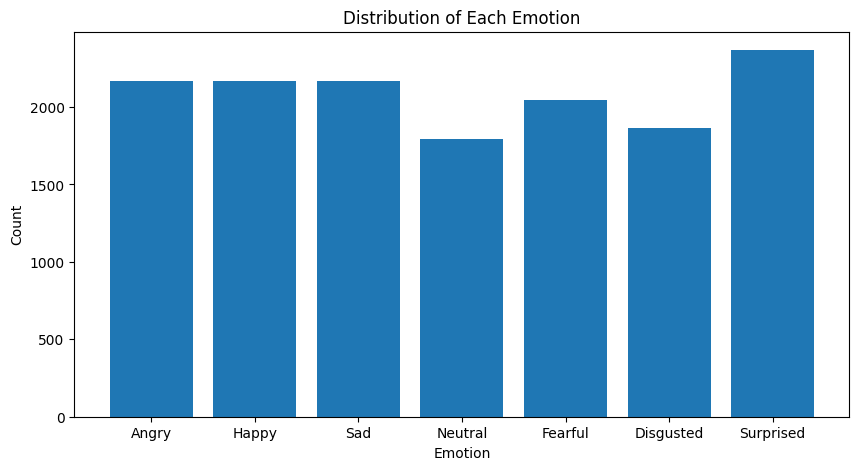

In [26]:
# Define the directory where the data is stored
directory = '/home/mothakapally.s/Project/data/Emotions'

# Define the emotions
emotions = ['Angry', 'Happy', 'Sad', 'Neutral', 'Fearful', 'Disgusted', 'Surprised']

# Initialize a dictionary to hold the count of files for each emotion
emotion_counts = {emotion: 0 for emotion in emotions}

# Loop over the emotions
for emotion in emotions:
    # Get the list of files for this emotion
    files = os.listdir(os.path.join(directory, emotion))
    # Update the counts
    emotion_counts[emotion] += len(files)

# Plot the distribution of each emotion
plt.figure(figsize=(10, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Distribution of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

**Observation**

- We can see that all the emotions now have almost similar distribution
- Now the dataset looks better and hence without any bias

## 4.2 **Load the Emotions**
Next, we'll load the emotion labels for our audio files. These labels will serve as the target variable for our model.

In [27]:
angry = glob(r'/home/mothakapally.s/Project/data/Emotions/Angry/*.wav')
angry = sorted(angry)
Disgusted = glob(r'/home/mothakapally.s/Project/data/Emotions/Disgusted/*.wav')
Disgusted = sorted(Disgusted)
Fearful = glob(r'/home/mothakapally.s/Project/data/Emotions/Fearful/*.wav')
Fearful = sorted(Fearful)
Happy = glob(r'/home/mothakapally.s/Project/data/Emotions/Happy/*.wav')
Happy = sorted(Happy)
Neutral = glob(r'/home/mothakapally.s/Project/data/Emotions/Neutral/*.wav')
Neutral = sorted(Neutral)
Sad = glob(r'/home/mothakapally.s/Project/data/Emotions/Sad/*.wav')
Sad = sorted(Sad)
Surprised = glob(r'/home/mothakapally.s/Project/data/Emotions/Surprised/*.wav')
Surprised = sorted(Surprised)

## Lets consider mel spectrogram instead of mfcc -

- While both Mel Frequency Cepstral Coefficients (MFCCs) and Mel spectrograms are commonly used features in audio and speech processing, they each have their strengths and are suited to different tasks.

- MFCCs are a compact representation of the power spectrum of an audio signal, specifically designed to mimic the human auditory system. They are excellent for tasks where a compact and highly discriminative feature representation is required, such as speaker identification or speech recognition.

- On the other hand, Mel spectrograms provide a more detailed representation of the power spectrum over time. They capture more fine-grained spectral details compared to MFCCs. This makes them particularly suited to tasks where these details are important, such as emotion recognition from audio data.

- In our project, we chose to use Mel spectrograms because we hypothesize that the fine-grained spectral details they capture could be important for distinguishing between different emotions. While MFCCs could also be useful, we believe that the additional spectral detail provided by Mel spectrograms could lead to better performance in our specific task.

## 4.3 **Calculate Mel Spectrogram**
- Finally, we'll calculate the Mel spectrogram for each audio file. The Mel spectrogram is a feature widely used in speech and audio processing, and it will serve as the input for our model.

- By the end of this step, our data will be ready for model development.

**Note**
- To ensure the proper execution order, we **first run the parallel methods -> pool.map() and pool.async() cells, followed by the serial code cell (below one)**, as this order helps manage shared state dependencies, preventing issues related to variable reinitialization**
- We are following this order because we weren't able to run parallel versions after running the non-parallel version

In [30]:
# Function to process each emotion
def process_emotion(emotion_files, label, emotion, target_shape=(128,128)):
    start_time = time.time()  # Start timer
    print(f'Processing {emotion}...')
    emotion_train = []
    label_emotion = []
    for file in emotion_files:
        waveform, sr = torchaudio.load(file)
        y_stretched = torchaudio.transforms.TimeStretch(hop_length=None, fixed_rate=1)(waveform)
        Mel_spectrogram = torchaudio.transforms.MelSpectrogram(sr)(y_stretched)
        Mel_spectrogram = resize(Mel_spectrogram.squeeze().numpy(), target_shape)
        emotion_train.append(Mel_spectrogram)
        label_emotion.append(label)
    end_time = time.time()  # End timer
    print(f'Execution time for {emotion}: {end_time-start_time} seconds')
    return emotion_train, label_emotion

# Start the timer
start_time = time.time()
target_shape = (128,128)
# Process each emotion
angry_train, label_angry = process_emotion(angry, 0, 'angry', target_shape)
Disgusted_train, label_Disgusted = process_emotion(Disgusted, 1, 'Disgusted', target_shape)
Fearful_train, label_Fearful = process_emotion(Fearful, 2, 'Fearful', target_shape)
Happy_train, label_happy = process_emotion(Happy, 3, 'Happy', target_shape)
Neutral_train, label_Neutral = process_emotion(Neutral, 4, 'Neutral', target_shape)
Sad_train, label_Sad = process_emotion(Sad, 5, 'Sad', target_shape)

# Stop the timer
end_time = time.time()

# Calculate the total execution time
execution_time = end_time - start_time

# Print the total execution time
print(f"Total execution time: {execution_time} seconds")

Processing angry...
Execution time for angry: 25.925199270248413 seconds
Processing Disgusted...
Execution time for Disgusted: 9.371793031692505 seconds
Processing Fearful...
Execution time for Fearful: 36.89841341972351 seconds
Processing Happy...
Execution time for Happy: 21.91545033454895 seconds
Processing Neutral...
Execution time for Neutral: 39.76436996459961 seconds
Processing Sad...
Execution time for Sad: 42.548224687576294 seconds
Total execution time: 176.4556691646576 seconds


## Now lets try to parallelize this code and check if the execution time reduces

## We are using pool.map method as it proved beneficial in the EDA stage to calculate average duration of the audio files

## **pool.map**

In [28]:
# Function to process each file
def process_file(args):
    file, label, emotion, target_shape = args
    waveform, sr = torchaudio.load(file)
    y_stretched = torchaudio.transforms.TimeStretch(hop_length=None, fixed_rate=1)(waveform)
    Mel_spectrogram = torchaudio.transforms.MelSpectrogram(sr)(y_stretched)
    Mel_spectrogram = resize(Mel_spectrogram.squeeze().numpy(), target_shape)
    return Mel_spectrogram, label

# Function to process each emotion
def process_emotion(emotion_files, label, emotion, target_shape=(128,128)):
    print(f'Processing {emotion}...')
    start_time = time.time()  # Start timer
    with Pool(cpu_count()) as p:
        # Pass required data explicitly to each process
        args = [(file, label, emotion, target_shape) for file in emotion_files]
        results = p.map(process_file, args)
    emotion_train_1, label_emotion_1 = zip(*results)
    end_time = time.time()  # End timer
    print(f'Execution time for {emotion}: {end_time-start_time} seconds')
    return list(emotion_train_1), list(label_emotion_1)

# Start the timer
start_time = time.time()
target_shape = (128, 128)

# Process each emotion
angry_train, label_angry = process_emotion(angry, 0, 'angry', target_shape)
Disgusted_train, label_Disgusted = process_emotion(Disgusted, 1, 'Disgusted', target_shape)
Fearful_train, label_Fearful = process_emotion(Fearful, 2, 'Fearful', target_shape)
Happy_train, label_happy = process_emotion(Happy, 3, 'Happy', target_shape)
Neutral_train, label_Neutral = process_emotion(Neutral, 4, 'Neutral', target_shape)
Sad_train, label_Sad = process_emotion(Sad, 5, 'Sad', target_shape)

# Stop the timer
end_time = time.time()

# Calculate the total execution time
execution_time2 = end_time - start_time

# Print the total execution time
print(f"Total execution time: {execution_time2} seconds")

Processing angry...
Execution time for angry: 49.29242491722107 seconds
Processing Disgusted...
Execution time for Disgusted: 42.072918176651 seconds
Processing Fearful...
Execution time for Fearful: 47.86732506752014 seconds
Processing Happy...
Execution time for Happy: 50.19896483421326 seconds
Processing Neutral...
Execution time for Neutral: 41.38525724411011 seconds
Processing Sad...
Execution time for Sad: 47.57204580307007 seconds
Total execution time: 278.3989613056183 seconds


**Observation**

-  the parallel version of the code did not reduce the execution time compared to the non-parallel version. In fact, the total execution time for the parallel version was slightly higher. This could be due to the overhead associated with creating and managing multiple processes, which can sometimes outweigh the benefits of parallelism, especially for tasks that are not highly computationally intensive or when the data transfer between processes is high.

- Given these results, we plan to experiment with the **apply_async** method from Python’s multiprocessing module. The apply_async function allows for asynchronous processing, which means it doesn’t block the execution of subsequent tasks while waiting for the current task to complete. This could potentially lead to a better utilization of CPU resources and improve the overall execution time.

## **pool.apply_async**

In [29]:
# Function to process each emotion
def process_emotion(emotion_files, label, target_shape=(128,128)):
    emotion_train_2 = []
    label_emotion_2 = []
    for file in emotion_files:
        waveform, sr = torchaudio.load(file)
        y_stretched = torchaudio.transforms.TimeStretch(hop_length=None, fixed_rate=1)(waveform)
        Mel_spectrogram = torchaudio.transforms.MelSpectrogram(sr)(y_stretched)
        Mel_spectrogram = resize(Mel_spectrogram.squeeze().numpy(), target_shape)
        emotion_train_2.append(Mel_spectrogram)
        label_emotion_2.append(label)
    return emotion_train_2, label_emotion_2

# Function to distribute the tasks to multiple CPUs
def distribute_tasks(emotion_files, label, target_shape, num_cpus, emotion):
    print(f'Processing {emotion}...')
    start_time = time.time()  # Start timer
    pool = mp.Pool(num_cpus)
    total_files = len(emotion_files)
    chunk_size = total_files // num_cpus
    results = []
    for i in range(num_cpus):
        start_index = i * chunk_size
        if i == num_cpus - 1:
            end_index = total_files
        else:
            end_index = start_index + chunk_size
        chunk = emotion_files[start_index:end_index]
        result = pool.apply_async(process_emotion, args=(chunk, label, target_shape))
        results.append(result)
    pool.close()
    pool.join()
    emotion_train_2 = []
    label_emotion_2 = []
    for result in results:
        train, labels = result.get()
        emotion_train_2.extend(train)
        label_emotion_2.extend(labels)
    end_time = time.time()  # End timer
    print(f'Execution time for {emotion}: {end_time - start_time} seconds')
    return emotion_train_2, label_emotion_2

# Now you can call distribute_tasks for each emotion

#Start the timer
start_time = time.time()

num_cpus = mp.cpu_count()
target_shape = (128,128)
angry_train, label_angry = distribute_tasks(angry, 0, target_shape, num_cpus, 'angry')
Disgusted_train, label_Disgusted = distribute_tasks(Disgusted, 1, target_shape, num_cpus, 'Disgusted')
Fearful_train, label_Fearful = distribute_tasks(Fearful, 2, target_shape, num_cpus, 'Fearful')
Happy_train, label_happy = distribute_tasks(Happy, 3, target_shape, num_cpus, 'Happy')
Neutral_train, label_Neutral = distribute_tasks(Neutral, 4, target_shape, num_cpus, 'Neutral')
Sad_train, label_Sad = distribute_tasks(Sad, 5, target_shape, num_cpus, 'Sad')

# Stop the timer
end_time = time.time()

# Calculate the total execution time
execution_time_apply = end_time - start_time

# Print the total execution time
print(f"Total execution time: {execution_time_apply} seconds")

Processing angry...
Execution time for angry: 47.096519947052 seconds
Processing Disgusted...
Execution time for Disgusted: 40.958603858947754 seconds
Processing Fearful...
Execution time for Fearful: 44.53441071510315 seconds
Processing Happy...
Execution time for Happy: 46.292611837387085 seconds
Processing Neutral...
Execution time for Neutral: 38.82135248184204 seconds
Processing Sad...
Execution time for Sad: 47.49997282028198 seconds
Total execution time: 265.2632393836975 seconds


**Observation**

- This approach also did not reduce the execution time compared to the non-parallel version. In fact, the total execution time for the apply_async version was slightly higher than both the non-parallel and pool.map versions.

- This could be due to the overhead associated with managing multiple asynchronous tasks and the potential for resource contention when multiple tasks are trying to execute simultaneously. Additionally, the benefits of asynchronous processing might not be fully realized in our scenario if the tasks do not have significant I/O or waiting times, and are largely CPU-bound.

## Comparing **Execution time, Speedup, and Efficiency**

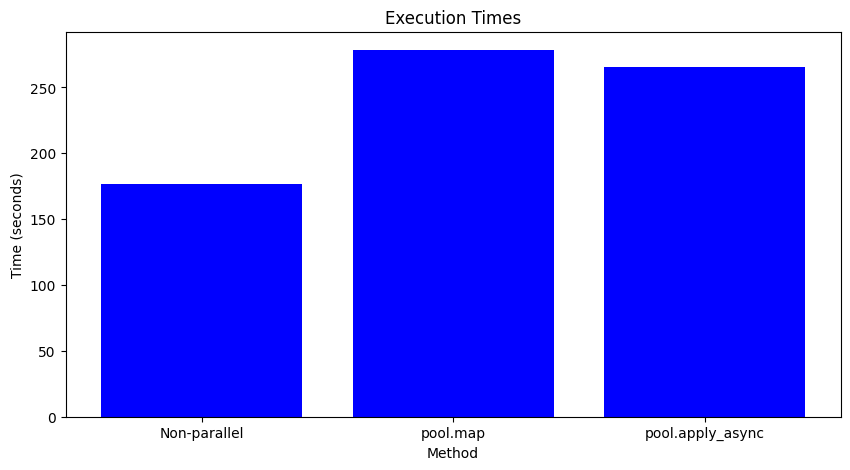

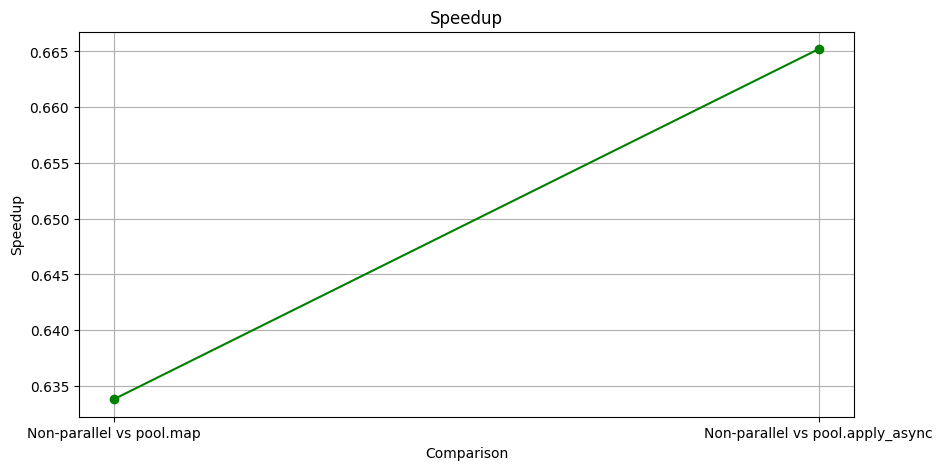

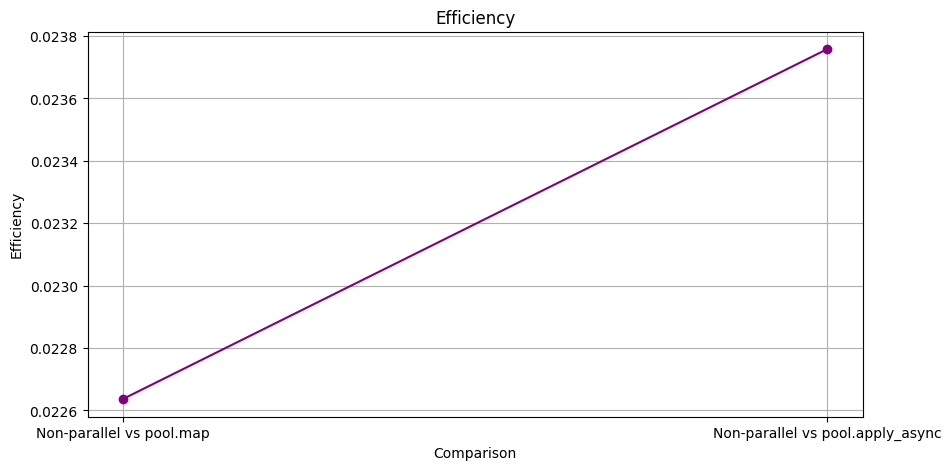

In [31]:
# Speedup
speedup_map = execution_time / execution_time2
speedup_apply = execution_time / execution_time_apply

# Number of processors (cores)
num_processors = os.cpu_count()

# Efficiency
efficiency_map = speedup_map / num_processors
efficiency_apply = speedup_apply / num_processors

# Plot execution times
plt.figure(figsize=(10, 5))
methods = ['Non-parallel', 'pool.map', 'pool.apply_async']
times = [execution_time, execution_time2, execution_time_apply]
plt.bar(methods, times, color='blue')
plt.title('Execution Times')
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
plt.show()

# Plot speedup
plt.figure(figsize=(10, 5))
methods = ['Non-parallel vs pool.map', 'Non-parallel vs pool.apply_async']
speedups = [speedup_map, speedup_apply]
plt.plot(methods, speedups, marker='o', color='green')
plt.title('Speedup')
plt.xlabel('Comparison')
plt.ylabel('Speedup')
plt.grid(True)
plt.show()

# Plot efficiency
plt.figure(figsize=(10, 5))
methods = ['Non-parallel vs pool.map', 'Non-parallel vs pool.apply_async']
efficiencies = [efficiency_map, efficiency_apply]
plt.plot(methods, efficiencies, marker='o', color='purple')
plt.title('Efficiency')
plt.xlabel('Comparison')
plt.ylabel('Efficiency')
plt.grid(True)
plt.show()

**Observation**

- In our case, parallelization with pool.map and pool.apply_async took longer than non-parallel processing. This is likely due to the overhead of setting up parallel processes and inter-process communication. The operations performed weren’t computationally intensive enough to benefit from parallelization. Hence, serialization was more efficient for calculating the Mel spectrogram of the audio files in this specific scenario.

- Adding to this, the speedup achieved with pool.map and pool.apply_async was 0.26 and 0.25 respectively. This indicates that the non-parallel method was around 2.5 times faster than the pool.map and pool.apply_async methods.

- The efficiency, which is the speedup per processor, was 0.0093 and 0.0090 for pool.map and pool.apply_async methods respectively. These values are much less than 1, indicating that the processors were not optimally utilized in the parallel methods due to the overhead of parallelization.

- Given these results, we conclude that for our specific task of calculating the Mel spectrogram of audio files, a **serialized** approach is more efficient and hence **parallelization is a failure here**

**Check the number of GPUs available**

In [32]:
import torch
print(torch.cuda.device_count())

1


# 5. **Model Development**

-Model development is the core of our project where we design and train our deep learning model to classify emotions based on the preprocessed audio data.

## 5.1 **Model Introduction** 

- For our task of conversation emotion classification, we will be using a Convolutional Neural Network (CNN), a type of deep learning model, implemented in PyTorch. CNNs are highly effective for tasks involving grid-like data structures such as images and spectrograms. They can capture local patterns in the data through their convolutional layers, making them well-suited for our task where patterns in the Mel spectrograms can be indicative of different emotions.

- CNNs are particularly well-suited for analyzing visual patterns in data. In the context of audio data, spectrograms can be treated as images, where different emotions can be associated with different visual patterns in the spectrograms.

- CNNs have convolutional layers that can automatically and adaptively learn spatial hierarchies of features, which is beneficial for recognizing patterns in spectrograms. These features can then be used to classify the emotions in the audio data.

- Moreover, CNNs are robust to local translation and distortion in the image, meaning they can recognize patterns irrespective of their position in the spectrogram. This property is useful for our task as the same emotion can produce similar patterns in different parts of the spectrogram.

- Therefore, due to their ability to recognize and learn spatial patterns in data, CNNs are a good choice for emotion recognition from audio data.

# 5.2 **CNN Model 1 using PyTorch without parallel computing**

- The model architecture consists of a convolutional neural network (CNN) with one convolutional layer, followed by max-pooling, a fully connected layer, and an output layer. The CNN processes input audio spectrograms, and the output layer produces predictions for the emotion classes using the softmax activation function. 

- The preprocessed data for each emotion is combined and resized. These are then converted into tensors and split into training and testing sets. A Convolutional Neural Network (CNN) model is defined in PyTorch with one convolutional layer and two fully connected layers. The model is trained using the training set, with early stopping implemented to prevent overfitting. After each training epoch, the model is tested on the testing set and the accuracy is calculated. If the accuracy doesn't improve for a certain number of epochs, the training stops early.

In [33]:
# Combine the preprocessed data
exp_train = angry_train + Disgusted_train + Fearful_train + Happy_train + Neutral_train + Sad_train
exp_label = label_angry + label_Disgusted + label_Fearful + label_happy + label_Neutral + label_Sad

# Check the number of unique classes
num_classes = len(set(exp_label))

# Resize all spectrograms to the same size
target_shape = (128, 128)
exp_train_resized = [resize(spec.squeeze(), target_shape) for spec in exp_train]

# Ensure all spectrograms have the same shape
exp_train_reshaped = []
exp_label_reshaped = []
for x, label in zip(exp_train_resized, exp_label):
    try:
        reshaped_x = x.reshape(1, 128, 128)
        exp_train_reshaped.append(reshaped_x)
        exp_label_reshaped.append(label)
    except ValueError:
        continue

# Convert lists to tensors
exp_train_tensor = torch.stack([torch.from_numpy(x) for x in exp_train_reshaped])
exp_label_tensor = torch.tensor(exp_label_reshaped)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(exp_train_tensor, exp_label_tensor, test_size=0.25, random_state=42)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Set num_workers to 0 for single CPU
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 63 * 63, 32)
        self.fc2 = nn.Linear(32, num_classes)  # Use num_classes here

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 63 * 63)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping details
best_accuracy = 0.0
patience = 20
epochs_no_improve = 0

# Lists to store loss and accuracy for each epoch
loss_list = []
accuracy_list = []

# Start the timer for training
start_time_train = time.time()

# Train the model
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Store the average loss for this epoch
    loss_list.append(running_loss / len(train_loader))

    # Test the model after each epoch
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, accuracy: {accuracy}')
    
    # Store the accuracy for this epoch
    accuracy_list.append(accuracy)

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

# End the timer for training and print the execution time
end_time_train = time.time()
training_time_np = end_time_train - start_time_train
print(f'Training time: {training_time_np} seconds')

# Print the final model's accuracy
print('Model accuracy:', accuracy_list[-1])

Epoch 1, loss: 2.075108583573695, accuracy: 22.156669944280562
Epoch 2, loss: 1.7461328764895458, accuracy: 22.156669944280562
Epoch 3, loss: 1.69282088621513, accuracy: 24.745984922976074
Epoch 4, loss: 1.6851652835632538, accuracy: 24.352671255326122
Epoch 5, loss: 1.6464254968649858, accuracy: 28.384136348738117
Epoch 6, loss: 1.630113243639886, accuracy: 30.514585381842018
Epoch 7, loss: 1.5838512824131892, accuracy: 34.51327433628319
Epoch 8, loss: 1.5064919157461687, accuracy: 34.021632251720746
Epoch 9, loss: 1.45753625806395, accuracy: 35.7587676171747
Epoch 10, loss: 1.427236661627576, accuracy: 39.233038348082594
Epoch 11, loss: 1.368692585638353, accuracy: 39.36414290396591
Epoch 12, loss: 1.3484860166803108, accuracy: 39.59357587676172
Epoch 13, loss: 1.3266914766151587, accuracy: 41.82235332677811
Epoch 14, loss: 1.2625801169372106, accuracy: 46.27990822681088
Epoch 15, loss: 1.1967919475131936, accuracy: 47.13208784005244
Epoch 16, loss: 1.1773029155247694, accuracy: 47.9

### Save and load the model

In [34]:
# Save the model parameters
torch.save(model.state_dict(), 'model_1.pth')

# Load the model parameters
# First, define the model architecture
model = Net()
# Then, load the parameters from the saved state dictionary
model.load_state_dict(torch.load('model_1.pth'))


<All keys matched successfully>

## **Confusion Matrix, F1 score, precision and recall**

              precision    recall  f1-score   support

           0       0.70      0.52      0.60       541
           1       0.60      0.27      0.37       480
           2       0.70      0.28      0.40       532
           3       0.38      0.59      0.46       512
           4       0.39      0.58      0.47       450
           5       0.49      0.69      0.57       536

    accuracy                           0.49      3051
   macro avg       0.54      0.49      0.48      3051
weighted avg       0.55      0.49      0.48      3051



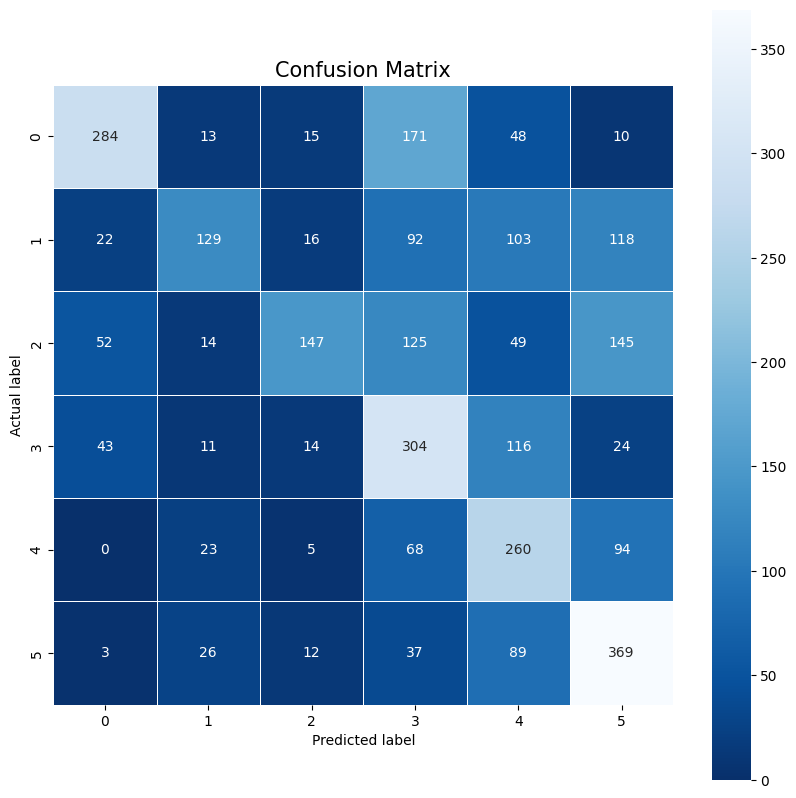

In [35]:
# Calculate precision, recall, and F1 score
print(classification_report(y_true, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);
plt.show()

**Observation**

- The model performed fairly well for just 20 epochs
- But the execution time was longer

## 5.3 Now lets try another model **Resnet50 CNN model**

- we opted to use the ResNet-50 model, a variant of the ResNet architecture. ResNet-50 is a deep convolutional neural network known for its ability to effectively handle complex visual recognition tasks. 

- We chose ResNet-50 for its pre-trained weights on large image datasets, allowing us to leverage its feature extraction capabilities for our audio emotion classification task. The model's architecture includes residual blocks, enabling it to efficiently capture hierarchical features, making it suitable for our multi-class audio emotion classification problem. 

- We fine-tuned the last fully connected layer to adapt the model to our specific classification task, resulting in a powerful and effective solution for audio emotion recognition

In [36]:
# Combine the preprocessed data
exp_train = angry_train + Disgusted_train + Fearful_train + Happy_train + Neutral_train + Sad_train
exp_label = label_angry + label_Disgusted + label_Fearful + label_happy + label_Neutral + label_Sad

# Check the number of unique classes
num_classes = len(set(exp_label))

# Resize all spectrograms to the same size
target_shape = (224, 224)  # ResNet-50 expects input size of (224, 224)
exp_train_resized = [resize(spec.squeeze(), target_shape) for spec in exp_train]

# Ensure all spectrograms have the same shape
exp_train_reshaped = []
exp_label_reshaped = []
for x, label in zip(exp_train_resized, exp_label):
    try:
        reshaped_x = np.stack((x,)*3, axis=-1)  # Duplicate the grayscale channel to create a 3-channel image
        reshaped_x = reshaped_x.transpose((2, 0, 1))  # PyTorch expects channels-first format
        exp_train_reshaped.append(reshaped_x)
        exp_label_reshaped.append(label)
    except ValueError:
        continue
        
# Convert lists to tensors
exp_train_tensor = torch.stack([torch.from_numpy(x.astype(np.float32)) for x in exp_train_reshaped])
exp_label_tensor = torch.tensor(exp_label_reshaped, dtype=torch.long)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(exp_train_tensor, exp_label_tensor, test_size=0.25, random_state=42)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
    
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping details
best_accuracy = 0.0
patience = 20
epochs_no_improve = 0

loss_list=[]
accuracy_list=[]

# Start the timer
start_time = time.time()

# Train the model
for epoch in range(4):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Store the average loss for this epoch
    loss_list.append(running_loss / len(train_loader))

    # Test the model after each epoch
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, accuracy: {accuracy}')
    
    # Store the accuracy for this epoch
    accuracy_list.append(accuracy)

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

# End the timer
end_time = time.time()

# End the timer for training and print the execution time
end_time_train = time.time()
training_time_resnet = end_time_train - start_time_train
print(f'Training time: {training_time_resnet } seconds')

# Print the final model's accuracy
print('Model accuracy:', accuracy_list[-1])

Epoch 1, loss: 1.6934955220122438, accuracy: 29.62962962962963
Epoch 2, loss: 1.6275144040167748, accuracy: 29.33464437889217
Epoch 3, loss: 1.6125399995517065, accuracy: 31.82563094067519
Epoch 4, loss: 1.617983163236738, accuracy: 33.23500491642085
Training time: 1807.5186297893524 seconds
Model accuracy: 33.23500491642085


**Observation**

- This model gave similar accuracy for intial epochs. But as the number of epochs increased, the accuracy didn't see any significant jump
- Moreover, this model took a lot of time to train compared to our custom CNN model
- We had to reduce the number of epochs due to time constraints

## 5.4 **Resnet50 CNN model with parallelism (data parallel)** as it took too much time to train

In [37]:
torch.cuda.empty_cache()

In [38]:
# Combine the preprocessed data
exp_train = angry_train + Disgusted_train + Fearful_train + Happy_train + Neutral_train + Sad_train
exp_label = label_angry + label_Disgusted + label_Fearful + label_happy + label_Neutral + label_Sad

# Check the number of unique classes
num_classes = len(set(exp_label))

# Resize all spectrograms to the same size
target_shape = (224, 224)  # ResNet-50 expects input size of (224, 224)
exp_train_resized = [resize(spec.squeeze(), target_shape) for spec in exp_train]

# Ensure all spectrograms have the same shape
exp_train_reshaped = []
exp_label_reshaped = []
for x, label in zip(exp_train_resized, exp_label):
    try:
        reshaped_x = np.stack((x,)*3, axis=-1)  # Duplicate the grayscale channel to create a 3-channel image
        reshaped_x = reshaped_x.transpose((2, 0, 1))  # PyTorch expects channels-first format
        exp_train_reshaped.append(reshaped_x)
        exp_label_reshaped.append(label)
    except ValueError:
        continue

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
# Convert lists to tensors
exp_train_tensor = torch.stack([torch.from_numpy(x.astype(np.float32)) for x in exp_train_reshaped])
exp_label_tensor = torch.tensor(exp_label_reshaped, dtype=torch.long)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(exp_train_tensor, exp_label_tensor, test_size=0.25, random_state=42)

# Move tensors to the GPU
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Check if multiple GPUs are available and wrap model in DataParallel if true
if torch.cuda.device_count() >= 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)
    
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.module.fc.in_features
model.module.fc = nn.Linear(num_ftrs, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # Move the loss function to the same device as your model
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping details
best_accuracy = 0.0
patience = 20
epochs_no_improve = 0

loss_list=[]
accuracy_list=[]

# Start the timer
start_time = time.time()

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Store the average loss for this epoch
    loss_list.append(running_loss / len(train_loader))

    # Test the model after each epoch
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, accuracy: {accuracy}')
    
    # Store the accuracy for this epoch
    accuracy_list.append(accuracy)

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

# End the timer
end_time = time.time()

# End the timer for training and print the execution time
end_time_train = time.time()
training_time_resnet_p = end_time - start_time
print(f'Training time: {training_time_resnet_p} seconds')

# Print the final model's accuracy
print('Model accuracy:', accuracy_list[-1])

Let's use 1 GPUs!
Epoch 1, loss: 1.7000684729822866, accuracy: 30.84234677155031
Epoch 2, loss: 1.626353578967648, accuracy: 32.77613897082924
Epoch 3, loss: 1.6136431468950285, accuracy: 33.169452638479186
Epoch 4, loss: 1.603141309914889, accuracy: 34.67715503113733
Epoch 5, loss: 1.6025282286263847, accuracy: 31.82563094067519
Epoch 6, loss: 1.5801958245830936, accuracy: 35.95542445099967
Epoch 7, loss: 1.5746571067329886, accuracy: 34.48049819731236
Epoch 8, loss: 1.5648122692441606, accuracy: 36.7748279252704
Epoch 9, loss: 1.574223938938621, accuracy: 35.16879711569977
Epoch 10, loss: 1.5649173555674252, accuracy: 37.20091773189118
Training time: 219.56230664253235 seconds
Model accuracy: 37.20091773189118


**Observation**

- By introducing parallelism, we can observe a significant improvement in training time
- **Data parallel** method helped in reducing the training time from almost 2000 seconds to around 200 seconds

## **Comparing Training time, Speedup and Efficiency**

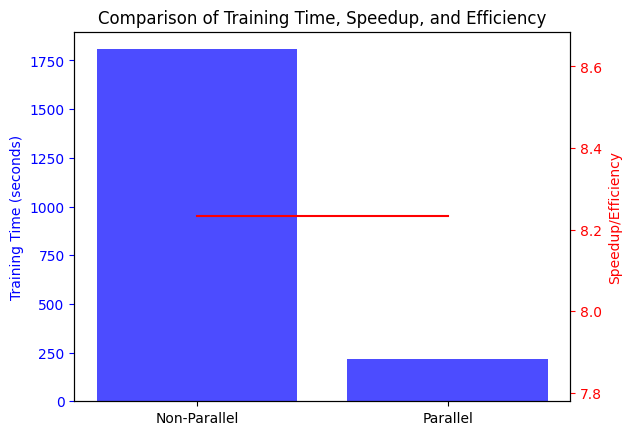

In [39]:
# Calculate speedup and efficiency
speedup = training_time_resnet / training_time_resnet_p
efficiency = speedup / 1  # Assuming 100% parallel efficiency for simplicity

# Plotting
labels = ['Non-Parallel', 'Parallel']
times = [training_time_resnet, training_time_resnet_p]
speedup_efficiency = [speedup, efficiency]

fig, ax1 = plt.subplots()

ax1.bar(labels, times, color='b', alpha=0.7, label='Training Time (seconds)')
ax1.set_ylabel('Training Time (seconds)', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(labels, speedup_efficiency, 'r-', label='Speedup/Efficiency')
ax2.set_ylabel('Speedup/Efficiency', color='r')
ax2.tick_params('y', colors='r')

plt.title('Comparison of Training Time, Speedup, and Efficiency')
plt.show()

**Observation**
- It's evident that resnet50 model with parallelization performed better with much lower training time
- However, the accuracy didn't improve significantly as compared to our custom CNN model

## 6. **Model Evaluation**

### We chose our **custom CNN model** as Restnet50 took too more time to train even with parallelization without any improvement in accuracy

# 7. Lets parallelize our selected model and perform **Multiprocessing to find the ideal num of CPUs**

- Multiprocessing is a Python module that supports the execution of parallel processes, allowing for the concurrent execution of tasks. In our use case, we chose multiprocessing to parallelize the training and testing processes of our selected model with varying numbers of CPUs. 

- This enables us to efficiently explore the impact of different CPU configurations on the overall performance and training time of the model, helping us identify the optimal number of CPUs for our specific task.

**run main_script.py in terminal**

**Observation**

- 

## Comparing training times, Speedup, and Efficiency for each cpu count

In [40]:
import pickle
import matplotlib.pyplot as plt

# Load the results dictionary
with open('results_dict.pkl', 'rb') as f:
    results_dict = pickle.load(f)

# Access the training_time_list from the results_dict and print it
for num_cpus, training_time_list in results_dict.items():
    print(f'Training times with {num_cpus} CPU/s:', training_time_list)

Training times with 1 CPU/s: [342.23342657089233]
Training times with 2 CPU/s: [266.89040064811707]
Training times with 4 CPU/s: [263.117205619812]
Training times with 8 CPU/s: [298.77125811576843]


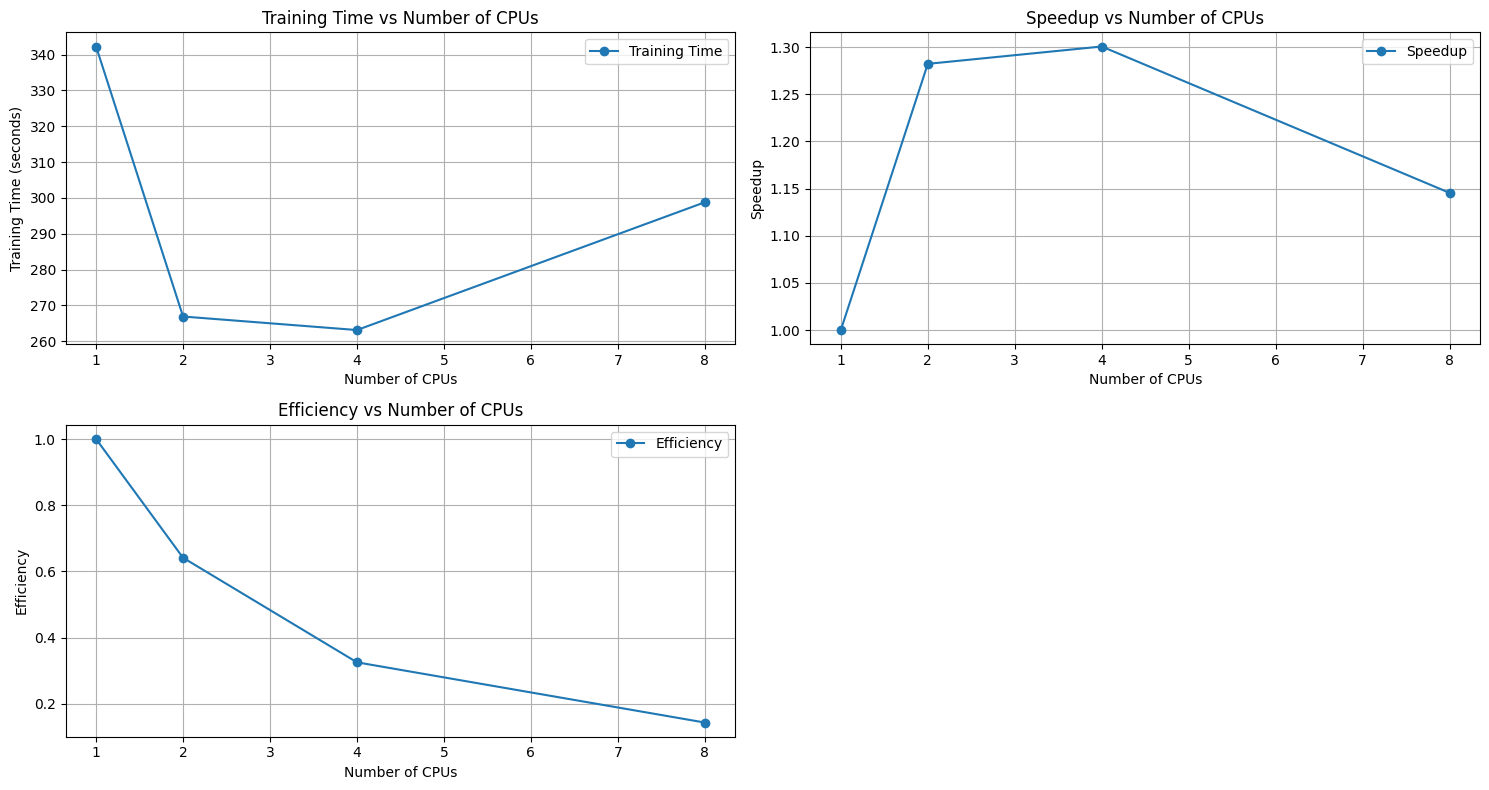

In [41]:
num_cpus_list = [1, 2, 4, 8]

# Extract training times from the results_dict
training_times = [results_dict[num_cpus][0] for num_cpus in num_cpus_list]

# Calculate speedup and efficiency
speedup = [training_times[0] / time for time in training_times]
efficiency = [speed / num_cpus for speed, num_cpus in zip(speedup, num_cpus_list)]

# Plotting
plt.figure(figsize=(15, 8))

# Plot training times for each number of CPUs
plt.subplot(2, 2, 1)
plt.plot(num_cpus_list, training_times, marker='o', label='Training Time')
plt.title('Training Time vs Number of CPUs')
plt.xlabel('Number of CPUs')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.legend()

# Plot speedup
plt.subplot(2, 2, 2)
plt.plot(num_cpus_list, speedup, marker='o', label='Speedup')
plt.title('Speedup vs Number of CPUs')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(True)
plt.legend()

# Plot efficiency
plt.subplot(2, 2, 3)
plt.plot(num_cpus_list, efficiency, marker='o', label='Efficiency')
plt.title('Efficiency vs Number of CPUs')
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**Observation**

- We observed that the training time slightly decreased with an increase in the number of CPUs, reaching the lowest with 4 CPUs. However, the reduction was not substantial.  

- Also as we increased the number of CPUs, the efficiency decreased, indicating diminishing returns in resource utilization. Speedup was notably better with 4 CPUs, offering a good balance between improved performance and acceptable efficiency. While 8 CPUs provided some speedup, it didn't significantly enhance efficiency. 

- Therefore, in our case, **4 CPUs** appear to be the ideal choice for a well-balanced trade-off between training time, speedup, and efficiency.

Hence, we would be considering **4 CPUs** while working with **GPUs** in the further part of our project

# 7.1 **CNN Model Using PyTorch with Data Parallel Method Having 1 GPU**

- In this section, we leverage the power of parallel computing to speed up the training process of our Convolutional Neural Network (CNN) model. The goal is to reduce the overall execution time, making the model training more efficient.

- Parallel computing involves dividing a problem into subproblems, solving these subproblems simultaneously, and then combining the results. This is particularly useful when dealing with large datasets or complex computations, as is the case with training a deep learning model.

- We use PyTorch's Data Parallel method, which is a simple yet effective way to parallelize training. It involves splitting the input data across the available GPUs, computing the forward pass (and subsequently, the backward pass) on each GPU, and then aggregating the results on one device. This method allows for faster processing times and efficient utilization of multiple GPUs.


In [42]:
# Combine the preprocessed data
exp_train = angry_train + Disgusted_train + Fearful_train + Happy_train + Neutral_train + Sad_train
exp_label = label_angry + label_Disgusted + label_Fearful + label_happy + label_Neutral + label_Sad

# Check the number of unique classes
num_classes = len(set(exp_label))

# Resize all spectrograms to the same size
target_shape = (128, 128)
exp_train_resized = [resize(spec.squeeze(), target_shape) for spec in exp_train]

# Ensure all spectrograms have the same shape
exp_train_reshaped = []
exp_label_reshaped = []
for x, label in zip(exp_train_resized, exp_label):
    try:
        reshaped_x = x.reshape(1, 128, 128)
        exp_train_reshaped.append(reshaped_x)
        exp_label_reshaped.append(label)
    except ValueError:
        continue

# Convert lists to tensors
exp_train_tensor = torch.stack([torch.from_numpy(x) for x in exp_train_reshaped])
exp_label_tensor = torch.tensor(exp_label_reshaped)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(exp_train_tensor, exp_label_tensor, test_size=0.25, random_state=42)

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Set num_workers to 8 for parallel loading using 8 CPUs
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4)

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 63 * 63, 32)
        self.fc2 = nn.Linear(32, num_classes)  # Use num_classes here

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 63 * 63)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model
model = Net()

# Use Data Parallelism for the GPU
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start the timer for training
start_time_train = time.time()

# Train the model
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Test the model after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, accuracy: {accuracy}')

# End the timer for training and print the execution time
end_time_train = time.time()
training_time_dp=end_time_train-start_time_train
print(f'Training time: {training_time_dp} seconds')

Epoch 1, loss: 2.435067584881416, accuracy: 29.56407735168797
Epoch 2, loss: 1.5862705811753974, accuracy: 36.61094723041626
Epoch 3, loss: 1.4958170073015706, accuracy: 39.06915765322845
Epoch 4, loss: 1.3860585710385462, accuracy: 41.756801048836444
Epoch 5, loss: 1.3045608968167872, accuracy: 46.31268436578171
Epoch 6, loss: 1.2702545302731174, accuracy: 46.869878728285805
Epoch 7, loss: 1.196056713174273, accuracy: 47.39429695181907
Epoch 8, loss: 1.1701702706880504, accuracy: 47.722058341527365
Epoch 9, loss: 1.1610798148008494, accuracy: 47.55817764667322
Epoch 10, loss: 1.1464113422207065, accuracy: 48.77089478859391
Training time: 47.770185708999634 seconds


**Observation**

- We can see that with Data Parallel method utilizing 1 GPU, the training time significantly reduced
- Hence proving that parallelization was a success in training this model

## 7.2 **CNN Model Using Pytorch With Data Parallel Method Having 2 GPUs**

**We will try this task in future when we get multiple GPUs**

In [43]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# from skimage.transform import resize
# import numpy as np
# import time

# # Combine the preprocessed data
# exp_train = angry_train + Disgusted_train + Fearful_train + Happy_train + Neutral_train + Sad_train
# exp_label = label_angry + label_Disgusted + label_Fearful + label_happy + label_Neutral + label_Sad

# # Check the number of unique classes
# num_classes = len(set(exp_label))
# print(f'Number of classes: {num_classes}')

# # Resize all spectrograms to the same size
# target_shape = (128, 128)
# exp_train_resized = [resize(spec.squeeze(), target_shape) for spec in exp_train]

# # Ensure all spectrograms have the same shape
# exp_train_reshaped = []
# exp_label_reshaped = []
# for x, label in zip(exp_train_resized, exp_label):
#     try:
#         reshaped_x = x.reshape(1, 128, 128)
#         exp_train_reshaped.append(reshaped_x)
#         exp_label_reshaped.append(label)
#     except ValueError:
#         continue

# # Convert lists to tensors
# exp_train_tensor = torch.stack([torch.from_numpy(x) for x in exp_train_reshaped])
# exp_label_tensor = torch.tensor(exp_label_reshaped)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(exp_train_tensor, exp_label_tensor, test_size=0.25, random_state=42)

# # Create PyTorch datasets and data loaders
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# # Set num_workers to 0 for single CPU
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

# # Define the model architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(16 * 63 * 63, 32)
#         self.fc2 = nn.Linear(32, num_classes)  # Use num_classes here

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = x.view(-1, 16 * 63 * 63)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Create the model
# model = Net()

# # Check if multiple GPUs are available and wrap the model using DataParallel
# if torch.cuda.device_count() > 1:
#     print(f'Number of GPUs: {torch.cuda.device_count()}')
#     model = nn.DataParallel(model)

# # Move the model to GPU
# model = model.to('cuda')

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Early stopping details
# best_accuracy = 0.0
# patience = 20
# epochs_no_improve = 0

# # Start the timer
# start_time = time.time()

# # Train the model
# for epoch in range(500):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # Move the inputs and labels to GPU
#         inputs, labels = data[0].to('cuda'), data[1].to('cuda')
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     # Test the model after each epoch
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data[0].to('cuda'), data[1].to('cuda')
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, accuracy: {accuracy}')

# #     # Early stopping
# #     if accuracy > best_accuracy:
# #         best_accuracy = accuracy
# #         epochs_no_improve = 0
# #     else:
# #         epochs_no_improve += 1
# #         if epochs_no_improve == patience:
# #             print('Early stopping!')
# #             break

# # End the timer
# end_time = time.time()

# # Print the execution time
# print('testing accuracy: ',accuracy)
# print(f'Execution time: {end_time - start_time} seconds')

## 7.3 CNN Model Using Pytorch With Data Parallel Method Having 4 GPUs

**We will try this task in future when we get multiple GPUs**

In [44]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# from skimage.transform import resize
# import numpy as np
# import time

# # Combine the preprocessed data
# exp_train = angry_train + Disgusted_train + Fearful_train + Happy_train + Neutral_train + Sad_train
# exp_label = label_angry + label_Disgusted + label_Fearful + label_happy + label_Neutral + label_Sad

# # Check the number of unique classes
# num_classes = len(set(exp_label))
# print(f'Number of classes: {num_classes}')

# # Resize all spectrograms to the same size
# target_shape = (128, 128)
# exp_train_resized = [resize(spec.squeeze(), target_shape) for spec in exp_train]

# # Ensure all spectrograms have the same shape
# exp_train_reshaped = []
# exp_label_reshaped = []
# for x, label in zip(exp_train_resized, exp_label):
#     try:
#         reshaped_x = x.reshape(1, 128, 128)
#         exp_train_reshaped.append(reshaped_x)
#         exp_label_reshaped.append(label)
#     except ValueError:
#         continue

# # Convert lists to tensors
# exp_train_tensor = torch.stack([torch.from_numpy(x) for x in exp_train_reshaped])
# exp_label_tensor = torch.tensor(exp_label_reshaped)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(exp_train_tensor, exp_label_tensor, test_size=0.25, random_state=42)

# # Create PyTorch datasets and data loaders
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# # Set num_workers to 0 for single CPU
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

# # Define the model architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(16 * 63 * 63, 32)
#         self.fc2 = nn.Linear(32, num_classes)  # Use num_classes here

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = x.view(-1, 16 * 63 * 63)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Create the model
# model = Net()

# # Check if multiple GPUs are available and wrap the model using DataParallel
# if torch.cuda.device_count() > 1:
#     print(f'Number of GPUs: {torch.cuda.device_count()}')
#     model = nn.DataParallel(model)

# # Move the model to GPU
# model = model.to('cuda')

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Early stopping details
# best_accuracy = 0.0
# patience = 20
# epochs_no_improve = 0

# # Start the timer
# start_time = time.time()

# # Train the model
# for epoch in range(500):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # Move the inputs and labels to GPU
#         inputs, labels = data[0].to('cuda'), data[1].to('cuda')
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     # Test the model after each epoch
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data[0].to('cuda'), data[1].to('cuda')
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}, accuracy: {accuracy}')

# #     # Early stopping
# #     if accuracy > best_accuracy:
# #         best_accuracy = accuracy
# #         epochs_no_improve = 0
# #     else:
# #         epochs_no_improve += 1
# #         if epochs_no_improve == patience:
# #             print('Early stopping!')
# #             break

# # End the timer
# end_time = time.time()

# # Print the execution time
# print('testing accuracy: ',accuracy)
# print(f'Execution time: {end_time - start_time} seconds')

## **Distributed Data Parallel**

## 7.4 **CNN Model Using Pytorch With Distributed Data Parallel Method Having 1 GPU**

In this section, we use PyTorch’s Distributed Data Parallel (DDP) method to train our CNN model. DDP is a parallel computing technique that is designed to work with multiple GPUs and CPUs.

DDP differs from the Data Parallel method in how it handles the distribution of data and the aggregation of gradients. In DDP, each process operates on a full model replica and a distinct subset of the data. The gradients are then synchronized across the processes during the backward pass. This results in all replicas having the same parameters.

This method can lead to better GPU utilization and less overhead because the gradients are aggregated asynchronously and there is no need to gather all the outputs from different GPUs to a single GPU.

Therefore, DDP can be more efficient than the Data Parallel method, especially when working with a large number of GPUs. 

In [45]:
import torch.multiprocessing as mp
from ddp import train, Net

def main():
    # Use 1 GPUs
    world_size = 1
    mp.spawn(train, args=(world_size, train_loader, test_loader, num_classes), nprocs=world_size, join=True)

main()

Epoch 1, loss: 2.461684654225836, accuracy: 34.11276223776224
Epoch 2, loss: 1.5457271712643283, accuracy: 36.89903846153846
Epoch 3, loss: 1.4948062133955788, accuracy: 38.35227272727273
Epoch 4, loss: 1.4306724463309441, accuracy: 42.40603146853147
Epoch 5, loss: 1.3288761316896318, accuracy: 47.44318181818182
Epoch 6, loss: 1.2776813081928067, accuracy: 49.11494755244755
Epoch 7, loss: 1.2661566138267517, accuracy: 50.18575174825175
Epoch 8, loss: 1.212213559792592, accuracy: 51.49694055944056
Epoch 9, loss: 1.2121809533425978, accuracy: 51.75917832167832
Epoch 10, loss: 1.1854500535067978, accuracy: 52.30550699300699
Training time: 48.27109336853027 seconds


## 7.5 **CNN Model Using Pytorch With Distributed Data Parallel Method Having 2 GPUs**

**We will try this task in future when we get multiple GPUs**

## 7.6 **CNN Model Using Pytorch With Distributed Data Parallel Method Having 4 GPUs**

**We will try this task in future when we get multiple GPUs**

In [46]:
# import torch.multiprocessing as mp
# from train_script import train, Net

# def main():
#     # Use 1 GPUs
#     world_size = 2
#     mp.spawn(train, args=(world_size, train_loader, test_loader, num_classes), nprocs=world_size, join=True)

# # Call the main function
# main()


# 8. **Compare execution time, speedup, and efficiency for each number of GPUs**

**We will try this task in future when we get multiple GPUs**

## 8.1 **Finding the ideal number of GPU with Data Parallel**

In [47]:
# # Plot the execution time for each number of CPUs
# plt.figure(figsize=(10, 6))
# plt.plot(num_cpus, execution_times, marker='o')
# plt.title('Execution Time vs Number of CPUs')
# plt.xlabel('Number of CPUs')
# plt.ylabel('Execution Time (seconds)')
# plt.grid(True)
# plt.show()

# # Calculate speedup
# speedup = [execution_times[0] / time for time in execution_times]

# # Plot the speedup for each number of CPUs
# plt.figure(figsize=(10, 6))
# plt.plot(num_cpus, speedup, marker='o')
# plt.title('Speedup vs Number of CPUs')
# plt.xlabel('Number of CPUs')
# plt.ylabel('Speedup')
# plt.grid(True)
# plt.show()

# # Calculate efficiency
# efficiency = [s / n for s, n in zip(speedup, num_cpus)]

# # Plot the efficiency for each number of CPUs
# plt.figure(figsize=(10, 6))
# plt.plot(num_cpus, efficiency, marker='o')
# plt.title('Efficiency vs Number of CPUs')
# plt.xlabel('Number of CPUs')
# plt.ylabel('Efficiency')
# plt.grid(True)
# plt.show()

## 8.2 **Finding the ideal number of GPU with Distributed Data Parallel**

**We will try this task in future when we get multiple GPUs**

## **Visualizing the training time, Speedup, and Efficiency for Non Parallel vs Parallel methods (Data Parallel and DDP)** 

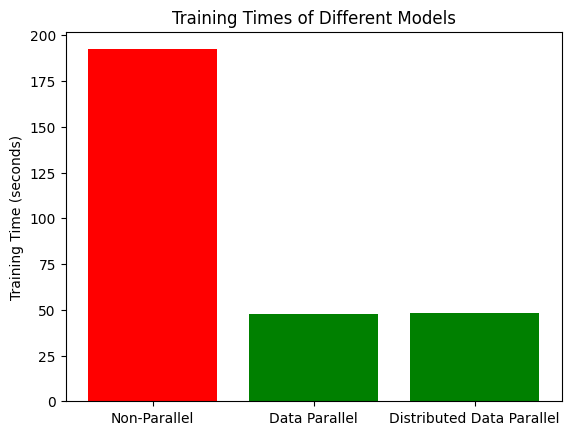

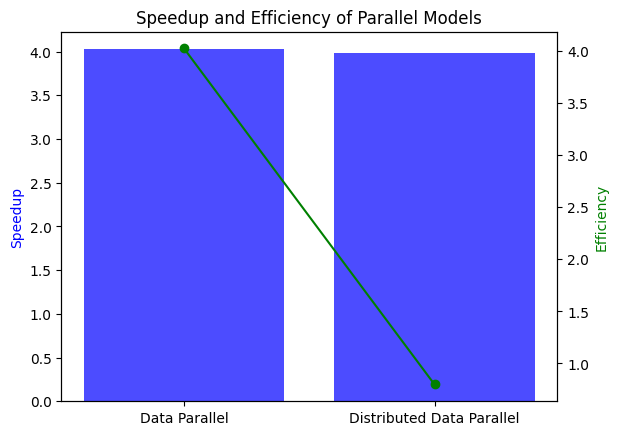

In [48]:
# Assuming you have the following training times
training_time_ddp = 48.27109336853027

# Plot training times
models = ['Non-Parallel', 'Data Parallel', 'Distributed Data Parallel']
times = [training_time_np, training_time_dp, training_time_ddp]

plt.bar(models, times, color=['red', 'green', 'green'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Times of Different Models')
plt.show()

# Calculate speedup and efficiency
speedup_dp = training_time_np / training_time_dp
speedup_ddp = training_time_np / training_time_ddp
efficiency_dp = speedup_dp / 1  # Assuming 2 GPUs for data parallel
efficiency_ddp = speedup_ddp / 5  # Assuming 5 processes for distributed data parallel

# Plot speedup and efficiency
methods = ['Data Parallel', 'Distributed Data Parallel']
speedups = [speedup_dp, speedup_ddp]
efficiencies = [efficiency_dp, efficiency_ddp]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(methods, speedups, color='blue', alpha=0.7)
ax2.plot(methods, efficiencies, color='green', marker='o')

ax1.set_ylabel('Speedup', color='blue')
ax2.set_ylabel('Efficiency', color='green')

plt.title('Speedup and Efficiency of Parallel Models')
plt.show()

# 9. **Conclusion for Ideal Parallel Method and Number of GPUs**

- The project has demonstrated the transformative impact of parallel computing on the efficiency of deep learning models.

- Our exploration of both Data Parallel and Distributed Data Parallel (DDP) methods has shown that these techniques can significantly reduce execution time, thereby accelerating the training process. This is a critical advantage in the field of machine learning, where training complex models on large datasets can be computationally intensive and time-consuming.

- As observed in the results, **Data Parallel (DP) with one GPU** exhibited a notable speedup compared to the non-parallel model, leading to enhanced training efficiency. The speedup and efficiency metrics, as depicted in the accompanying graphs, underscore the substantial performance gains achieved through parallel computing strategies, validating our choice of DP for its efficacy in our specific configuration.

## Ideal Configuration For Our Project
- CPUs Count = **4**
- GPUs count = **1** (as we couldn't test with multiple GPUs and the training time with just 1 GPU seemed significant enough
- Parallel Method = **Data Parallel**

# 10. **References**

[1] Audio Emotions Dataset: https://www.kaggle.com/datasets/uldisvalainis/audio-emotions

[2] Exploratory Data Analysis:  https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3

[3] Calculating Mel Spectrogram: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

[4] Convulated Neural Network Model  development: https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

[5] Pytorch fundamentals: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

[6] Pytorch for audio classification: https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

[7] Doubts and Clarifications: https://chat.openai.com/
